In [129]:
# In[1]:
# Cell 1: Setup and Imports
# Python Standard Library
from __future__ import annotations
import hashlib
import math
import os
import re
import sys
from datetime import datetime, timezone
from pathlib import Path
from typing import Dict, List, Optional

# Third-party Libraries
import duckdb as ddb
import pandas as pd
from rich.console import Console 
# For notebook display, pandas DataFrames are often preferred or use IPython.display.
from IPython.display import display, Markdown

# Matplotlib for plotting (optional, checked before use)
try:
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D 
except ModuleNotFoundError:
    plt = None
    Line2D = None
    print("Matplotlib not found. Plotting functions will be disabled. Install with: pip install matplotlib")

# python-magic for MIME sniffing (optional, checked before use)
try:
    import magic
except ModuleNotFoundError:
    magic = None
    print("python-magic not found. MIME type sniffing will use a default.")

# --- Globals & Constants ---
CON = Console(force_jupyter=False, force_terminal=False) # Better for notebook mixed output
WAREHOUSE = Path(".warehouse/cluster_logs.duckdb")
WAREHOUSE.parent.mkdir(parents=True, exist_ok=True) # Ensure warehouse directory exists

HASH_CHUNK = 1 << 16  # 64 KiB block size for streaming SHA-1

print(f"DuckDB Warehouse will be created/used at: {WAREHOUSE.resolve()}")

DuckDB Warehouse will be created/used at: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/.warehouse/cluster_logs.duckdb


In [130]:
# In[2]:
# Cell 2: Helper Functions

def _sha1(p: Path) -> str:
    """Computes SHA1 hash of a file."""
    h = hashlib.sha1()
    try:
        with p.open("rb") as fh:
            while blk := fh.read(HASH_CHUNK):
                h.update(blk)
        return h.hexdigest()
    except FileNotFoundError:
        # This case should ideally be handled before calling _sha1 if p might not exist.
        # For robustness, returning an empty string or raising a specific error.
        # CON.print(f"[yellow]File not found for hashing: {p}[/yellow]") 
        return "" 

def canonical_version_name(version_str: str) -> str:
    """Maps various raw version strings to a canonical project version name."""
    if not isinstance(version_str, str):
        return "UnknownVersion"
    
    v_lower = version_str.lower()

    # Order matters: more specific matches first
    if "v2" in v_lower and ("2.2" in v_lower or "scatter_halo" in v_lower or "scatter-halo" in v_lower):
        return "V2.2 ScatterHalo"
    if "v2" in v_lower and ("2.1" in v_lower or "broadcast_all" in v_lower or "broadcast-all" in v_lower):
        return "V2.1 BroadcastAll"
    if "v1" in v_lower or "serial" in v_lower:
        return "V1 Serial"
    if "v3" in v_lower or "cuda" in v_lower and "mpi" not in v_lower: # ensure not v4 or v5
        return "V3 CUDA"
    if "v4" in v_lower or ("mpi" in v_lower and "cuda" in v_lower): # Basic V4 check
        return "V4 MPI+CUDA"
    if "v5" in v_lower: # Assuming v5 implies MPI+CUDA as well
        return "V5 MPI+CUDA-Aware"
    
    # Fallback for log file names that might just contain the version number
    if "v2_1" in v_lower or "v2.1" in v_lower: return "V2.1 BroadcastAll"
    if "v2_2" in v_lower or "v2.2" in v_lower: return "V2.2 ScatterHalo"

    # Default if no specific pattern matches but starts with 'v' and a digit
    if v_lower.startswith("v") and len(v_lower) > 1 and v_lower[1].isdigit():
        return version_str # Keep original if it's a new variant not yet mapped
        
    return "Other" # Or version_str to keep unmapped ones visible

def _normalise_summary_df(df: pd.DataFrame, src: str) -> pd.DataFrame:
    """Maps various summary CSV formats to a canonical schema, including version normalization."""
    df = df.copy()
    output_columns = ["ts", "version", "np", "total_time_s"]
    for col in output_columns:
        if col not in df: 
            df[col] = pd.NA

    parsed_version = "UnknownVersion" # Default

    # Pattern 1: legacy run_summary_*.csv (Fall 2023 template)
    if {"Timestamp", "Version", "NP", "Time_ms"} <= set(df.columns):
        df["ts"]       = pd.to_datetime(df["Timestamp"],  utc=True, errors="coerce")
        parsed_version = df["Version"].astype(str).iloc[0] if not df.empty else "UnknownVersion" # Get from first row
        df["np"]       = pd.to_numeric(df["NP"], errors="coerce")
        if "Time_ms" in df.columns:
            df["total_time_s"] = pd.to_numeric(df["Time_ms"], errors="coerce").astype(float) / 1000.0
        else: df["total_time_s"] = pd.NA


    # Pattern 2: current summary_*.csv (Spring 2025 orchestrator)
    elif {"EntryTimestamp", "ProjectVariant", "NumProcesses"}.issubset(df.columns):
        df["ts"]       = pd.to_datetime(df["EntryTimestamp"], utc=True, errors="coerce")
        parsed_version = df["ProjectVariant"].astype(str).iloc[0] if not df.empty else "UnknownVersion"
        df["np"]       = pd.to_numeric(df["NumProcesses"], errors="coerce")
        time_col = None
        if "ExecutionTime_ms" in df.columns: time_col = "ExecutionTime_ms"
        elif "Time_ms" in df.columns: time_col = "Time_ms"
        
        if time_col and time_col in df.columns:
            df["total_time_s"] = pd.to_numeric(df[time_col], errors="coerce").astype(float) / 1000.0
        else: df["total_time_s"] = pd.NA
            
    # Pattern 3: for 'summary_nixos_*.csv' style logs
    elif {"timestamp", "version", "np", "time_ms"} <= set(df.columns):
        df["ts"]       = pd.to_datetime(df["timestamp"],  utc=True, errors="coerce")
        parsed_version = df["version"].astype(str).iloc[0] if not df.empty else "UnknownVersion"
        df["np"]       = pd.to_numeric(df["np"], errors="coerce") 
        if "time_ms" in df.columns:
            df["total_time_s"] = pd.to_numeric(df["time_ms"], errors="coerce").astype(float) / 1000.0
        else: df["total_time_s"] = pd.NA
    else:
        # CON.print(f"[dim]Unknown summary CSV schema: {src}[/dim]")
        return pd.DataFrame(columns=output_columns) 

    # Apply canonical version naming to the entire 'version' column
    df["version"] = df["version"].apply(canonical_version_name) # Important: apply to the existing version col

    df_filtered = df[output_columns].dropna(subset=["ts", "version", "np", "total_time_s"])
    return df_filtered

print("Helper and canonicalization functions defined.")

Helper and canonicalization functions defined.


In [131]:
# In[3]:
# Cell 3: Database Schema Definitions

SCHEMA_SQL = """
DROP VIEW IF EXISTS efficiency;
DROP VIEW IF EXISTS speedup;
DROP VIEW IF EXISTS run_stats;
DROP VIEW IF EXISTS best_runs;
DROP VIEW IF EXISTS perf_runs;

DROP TABLE IF EXISTS file_index;
DROP TABLE IF EXISTS summary_runs;
DROP TABLE IF EXISTS run_logs;
DROP TABLE IF EXISTS source_stats;

CREATE TABLE file_index (
  relpath  TEXT PRIMARY KEY, 
  sha1     TEXT,            
  size     BIGINT,
  mtime    TIMESTAMP,
  mime     TEXT
);
CREATE TABLE summary_runs (
  ts TIMESTAMP,
  version TEXT, -- This will store the CANONICAL version
  np INT,
  total_time_s DOUBLE
);
CREATE TABLE run_logs (
  relpath TEXT, -- Original relpath for traceability
  ts TIMESTAMP,
  version TEXT, -- This will store the CANONICAL version
  np INT,
  total_time_s DOUBLE
);
CREATE TABLE source_stats (
  relpath TEXT PRIMARY KEY, 
  loc INT,
  func_cnt INT,
  include_cnt INT,
  cuda_kernel_cnt INT
);
"""

DERIVED_VIEWS_SQL = """
CREATE OR REPLACE VIEW perf_runs AS
SELECT ts, version, np, total_time_s FROM summary_runs WHERE total_time_s IS NOT NULL AND total_time_s > 1e-9 AND version != 'Other' AND version != 'UnknownVersion'
UNION ALL
SELECT ts, version, np, total_time_s FROM run_logs WHERE total_time_s IS NOT NULL AND total_time_s > 1e-9 AND version != 'Other' AND version != 'UnknownVersion';

CREATE OR REPLACE VIEW best_runs AS
SELECT version, np, MIN(total_time_s)  AS best_s
FROM   perf_runs GROUP BY version, np;

CREATE OR REPLACE VIEW run_stats AS
SELECT version, np,
       COUNT(*)                            AS n,
       AVG(total_time_s)                  AS mean_s,
       STDDEV_SAMP(total_time_s)          AS sd_s, 
       CASE WHEN COUNT(*)>1 THEN 1.96*STDDEV_SAMP(total_time_s)/SQRT(COUNT(*)) ELSE NULL END AS ci95_s
FROM   perf_runs GROUP BY version, np;

CREATE OR REPLACE VIEW speedup AS
WITH base_runs AS (
    SELECT 
        version, 
        MIN(best_s) as t1 
    FROM best_runs 
    WHERE np = 1
    GROUP BY version
)
SELECT 
    br.version,
    br.np,
    b.t1 / br.best_s AS S 
FROM best_runs br 
JOIN base_runs b ON br.version = b.version
WHERE b.t1 IS NOT NULL AND br.best_s IS NOT NULL AND br.best_s > 1e-9; 

CREATE OR REPLACE VIEW efficiency AS
SELECT version, np, S/np AS E FROM speedup WHERE np > 0;
"""

print("Database schemas and view definitions ready (includes DROP statements for rebuilds).")

Database schemas and view definitions ready (includes DROP statements for rebuilds).


In [132]:
# In[4]:
# Cell 4: Data Ingestion Function

def ingest_data(root: Path, rebuild: bool = False):
    """Scans the root directory for CSV summaries, run logs, and source files,
    then loads the extracted data into the DuckDB warehouse."""
    
    if rebuild and WAREHOUSE.exists():
        WAREHOUSE.unlink()
        CON.print("[red]• Wiped existing warehouse[/red]")

    with ddb.connect(str(WAREHOUSE)) as con:
        con.execute(SCHEMA_SQL) # Executes DROPs and CREATEs

        seen: Dict[str, str] = dict(con.execute("SELECT relpath, sha1 FROM file_index").fetchall())
        rows_summary_dfs: List[pd.DataFrame] = [] # Changed to list of DataFrames
        rows_runlog:  List[tuple]       = []
        rows_srcstats:List[tuple]       = []
        processed_files_this_run = 0
        newly_indexed_count = 0

        CON.print(f"Starting ingestion from root: {root.resolve()}")
        all_files = list(root.rglob("*")) # Collect all files first to avoid issues with changing dir
        
        for p in all_files:
            if p.is_dir() or WAREHOUSE.resolve() == p.resolve(): 
                continue
            
            rel = str(p.relative_to(root))
            
            try:
                current_sha1 = _sha1(p)
                if not current_sha1 : continue # Skip if hashing failed

                current_stat = p.stat()
                size  = current_stat.st_size
                mtime = datetime.fromtimestamp(current_stat.st_mtime, tz=timezone.utc)
            except FileNotFoundError:
                continue

            if seen.get(rel) != current_sha1: # Process if new or modified
                newly_indexed_count +=1
                mime_type  = magic.from_file(str(p), mime=True) if magic else "application/octet-stream"

                # --- CSV Summaries ---
                if p.suffix.lower() == ".csv" and "summary" in p.name.lower():
                    try:
                        df_raw = pd.read_csv(p)
                        if not df_raw.empty:
                            df_norm = _normalise_summary_df(df_raw, rel) # Normalization includes canonical_version_name
                            if not df_norm.empty:
                                rows_summary_dfs.append(df_norm)
                    except pd.errors.EmptyDataError: pass
                    except Exception as e: CON.print(f"[yellow]CSV summary parse error {rel}: {e}[/yellow]")
                
                # --- Individual Run Logs ---
                elif p.suffix.lower() == ".log" and ("run_v" in p.name or "final_project_v" in p.name or "make_v" in p.name): 
                    try:
                        txt = p.read_text(errors="ignore")
                        m_time_val = None
                        time_patterns = [
                            r"AlexNet MPI\+CUDA Forward Pass completed in\s*([\d\.]+)\s*ms",
                            r"AlexNet CUDA Forward Pass completed in\s*([\d\.]+)\s*ms", 
                            r"AlexNet Serial Forward Pass completed in\s*([\d\.]+)\s*ms",
                            r"Serial execution finished successfully in\s*([\d\.]+)\s*ms",
                            r"MPI\+CUDA execution finished successfully in\s*([\d\.]+)\s*ms",
                            r"CUDA execution finished successfully in\s*([\d\.]+)\s*ms", 
                            r"MPI execution finished successfully in\s*([\d\.]+)\s*ms", 
                            r"Execution Time:\s*([\d\.]+)\s*ms", 
                            r"(?:Time|ExecutionTime)_ms[\s:=]*([\d\.]+)",
                            r"Total execution time:\s*([\d\.]+)\s*seconds", 
                        ]
                        for pat in time_patterns:
                            m_search = re.search(pat, txt, re.IGNORECASE)
                            if m_search:
                                m_time_val = float(m_search.group(1))
                                if "seconds" not in pat.lower(): m_time_val /= 1000.0
                                break 
                        
                        if m_time_val is not None:
                            raw_version_str = "unknown_version_in_log"
                            ver_pattern = r"(v\d(?:[\._]\d+(?:[\._][\w-]+)*)?(?:_[\w-]+)*)"
                            ver_match = re.search(ver_pattern, p.name, re.IGNORECASE)
                            if ver_match:
                                raw_version_str = ver_match.group(0)
                            else:
                                parent_name = p.parent.name
                                if parent_name.lower().startswith("v"):
                                    raw_version_str = parent_name
                            
                            canonical_ver = canonical_version_name(raw_version_str)
                            
                            np_m = re.search(r"np(\d+)", p.name, re.IGNORECASE)
                            np_val = int(np_m.group(1)) if np_m else 1
                            
                            ts_match_in_name = re.search(r"(\d{8}_\d{6})", p.name) # Check filename first
                            log_ts = mtime # Default to file mtime
                            if ts_match_in_name:
                                try:
                                    log_ts = datetime.strptime(ts_match_in_name.group(1), "%Y%m%d_%H%M%S").replace(tzinfo=timezone.utc)
                                except ValueError: pass # Keep mtime if parsing fails
                            
                            rows_runlog.append((rel, log_ts, canonical_ver, np_val, m_time_val))
                    except Exception as e: pass # CON.print(f"[yellow]Run log parse error {rel}: {e}[/yellow]")

                # --- Source File Statistics ---
                elif mime_type and ("text/" in mime_type or mime_type == 'application/octet-stream' or p.name.lower().endswith("makefile") or ".make" in p.name.lower()):
                    try:
                        code = p.read_text(errors="ignore")
                        loc = code.count("\n") + 1
                        func_cnt = len(re.findall(r"\b[A-Za-z_]\w*\s*\([^)]*\)\s*(?:const)?\s*\{", code))
                        inc_cnt = len(re.findall(r"^\s*#include", code, re.MULTILINE))
                        kern_cnt = code.count("__global__")
                        rows_srcstats.append((rel, loc, func_cnt, inc_cnt, kern_cnt))
                    except Exception as e: pass # CON.print(f"[yellow]Source stat parse error {rel}: {e}[/yellow]")
                
                # --- Update file_index Table ---
                try:
                    con.execute(
                        "INSERT INTO file_index (relpath, sha1, size, mtime, mime) VALUES (?, ?, ?, ?, ?) "
                        "ON CONFLICT(relpath) DO UPDATE SET sha1=excluded.sha1, size=excluded.size, mtime=excluded.mtime, mime=excluded.mime",
                        [rel, current_sha1, size, mtime, mime_type]
                    )
                except Exception as db_ex: CON.print(f"[red]DB Error indexing {rel}: {db_ex}[/red]")
            processed_files_this_run +=1


        if newly_indexed_count == 0 and not rebuild:
             CON.print("[cyan]• No new or modified files to process since last ingest.[/cyan]")
        elif newly_indexed_count > 0:
             CON.print(f"[green]• Indexed/Updated {newly_indexed_count} files in file_index.[/green]")


        # --- Bulk Insert Data ---
        inserted_summary_count = 0
        if rows_summary_dfs:
            df_all_summary = pd.concat(rows_summary_dfs, ignore_index=True).drop_duplicates().dropna(subset=['total_time_s', 'version', 'np'])
            if not df_all_summary.empty:
                # Ensure 'version' in df_all_summary is canonical before inserting
                # _normalise_summary_df already applies canonical_version_name
                con.register("df_all_summary_reg", df_all_summary)
                con.execute("INSERT INTO summary_runs SELECT ts, version, np, total_time_s FROM df_all_summary_reg")
                con.unregister("df_all_summary_reg")
                inserted_summary_count = len(df_all_summary)
        CON.print(f"[cyan]• {inserted_summary_count} summary rows ingested[/cyan]")

        inserted_log_count = 0
        if rows_runlog:
            # Ensure 'version' in rows_runlog (which is 3rd element, index 2) is already canonical
            df_runlog = pd.DataFrame(rows_runlog, columns=['relpath', 'ts', 'version', 'np', 'total_time_s']).drop_duplicates().dropna(subset=['total_time_s', 'version', 'np'])
            if not df_runlog.empty:
                con.executemany("INSERT INTO run_logs VALUES (?,?,?,?,?)", df_runlog.to_records(index=False).tolist())
                inserted_log_count = len(df_runlog)
        CON.print(f"[cyan]• {inserted_log_count} run_log rows ingested[/cyan]")

        inserted_src_count = 0
        if rows_srcstats:
            df_srcstats = pd.DataFrame(rows_srcstats, columns=['relpath', 'loc', 'func_cnt', 'include_cnt', 'cuda_kernel_cnt']).drop_duplicates(subset=['relpath'])
            if not df_srcstats.empty:
                con.executemany(
                    "INSERT INTO source_stats (relpath, loc, func_cnt, include_cnt, cuda_kernel_cnt) VALUES (?,?,?,?,?) "
                    "ON CONFLICT(relpath) DO UPDATE SET loc=excluded.loc, func_cnt=excluded.func_cnt, include_cnt=excluded.include_cnt, cuda_kernel_cnt=excluded.cuda_kernel_cnt",
                    df_srcstats.to_records(index=False).tolist()
                )
                inserted_src_count = len(df_srcstats)
        CON.print(f"[cyan]• {inserted_src_count} source files stats ingested/updated[/cyan]")

        con.execute(DERIVED_VIEWS_SQL)
        CON.print("[bold green]✓ Ingest complete. Derived views (re)created.[/bold green]")

print("Ingestion function 'ingest_data' defined.")

Ingestion function 'ingest_data' defined.


In [133]:
# In[5]:
# Cell 5: Perform Data Ingestion

project_root = Path(".") 
ingest_data(root=project_root / "final_project", rebuild=True) 

• Wiped existing warehouse


Starting ingestion from root: 
/home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/final_project
• Indexed/Updated 365 files in file_index.
• 144 summary rows ingested
• 131 run_log rows ingested
• 52 source files stats ingested/updated
✓ Ingest complete. Derived views (re)created.


In [134]:
# In[6]:
# Cell 6: Ad-hoc Querying and Database Inspection

def execute_query(sql_query: str) -> pd.DataFrame | None:
    """Executes a SQL query against the warehouse and returns a DataFrame."""
    try:
        with ddb.connect(str(WAREHOUSE), read_only=True) as con:
            df = con.execute(sql_query).fetchdf()
        return df
    except Exception as e:
        # For notebook, print might be better than CON.print
        print(f"SQL Query Error: {e}")
        return None

# --- Database Inspection ---
print("\n--- Database Objects (Tables and Views) ---")
all_db_objects = execute_query(
    """
    SELECT table_name as object_name, table_type as type 
    FROM information_schema.tables 
    WHERE table_schema = 'main'
    UNION ALL 
    SELECT view_name as object_name, 'VIEW' as type 
    FROM duckdb_views() 
    WHERE schema_name = 'main'
    ORDER BY type, object_name
    """
)
if all_db_objects is not None:
    display(all_db_objects)

print("\n--- Schema of 'best_runs' view ---")
best_runs_schema = execute_query("DESCRIBE best_runs;")
if best_runs_schema is not None:
    display(best_runs_schema)

print("\n--- Sample data from 'best_runs' (Grouped by canonical version, NP) ---")
sample_best_runs = execute_query("SELECT * FROM best_runs ORDER BY version, np LIMIT 10;")
if sample_best_runs is not None:
    display(sample_best_runs)

print("\n--- Perf run counts per canonical version ---")
version_counts = execute_query("SELECT version, COUNT(*) as count FROM perf_runs GROUP BY version ORDER BY version;")
if version_counts is not None:
    display(version_counts)


print("\n--- Total Source Files Analyzed ---")
source_file_count = execute_query("SELECT COUNT(*) as num_source_files FROM source_stats;")
if source_file_count is not None:
    display(source_file_count)


--- Database Objects (Tables and Views) ---


,object_name,type
0,file_index,BASE TABLE
1,run_logs,BASE TABLE
2,source_stats,BASE TABLE
3,summary_runs,BASE TABLE
4,best_runs,VIEW
5,best_runs,VIEW
6,duckdb_columns,VIEW
7,duckdb_columns,VIEW
8,duckdb_columns,VIEW
9,duckdb_constraints,VIEW



--- Schema of 'best_runs' view ---


,column_name,column_type,null,key,default,extra
0,version,VARCHAR,YES,None,None,None
1,np,INTEGER,YES,None,None,None
2,best_s,DOUBLE,YES,None,None,None



--- Sample data from 'best_runs' (Grouped by canonical version, NP) ---


,version,np,best_s
0,V1 Serial,1,0.601000
1,V2.1 BroadcastAll,1,0.702338
2,V2.1 BroadcastAll,2,0.734334
3,V2.1 BroadcastAll,4,0.793350
4,V2.2 ScatterHalo,1,0.507508
5,V2.2 ScatterHalo,2,0.315674
6,V2.2 ScatterHalo,4,0.186236
7,V3 CUDA,1,0.194456
8,V4 MPI+CUDA,1,0.182901
9,V4 MPI+CUDA,2,0.180931



--- Perf run counts per canonical version ---


,version,count
0,V1 Serial,14
1,V2.1 BroadcastAll,37
2,V2.2 ScatterHalo,38
3,V3 CUDA,11
4,V4 MPI+CUDA,31



--- Total Source Files Analyzed ---


,num_source_files
0,52


In [135]:
# In[7]:
# Cell 7: Display Run Statistics

print("\n--- Run Statistics (Time in seconds, for Canonical Versions) ---")
run_stats_df = execute_query("""
    SELECT version, np, n, 
           ROUND(mean_s, 4) as mean_s, 
           ROUND(sd_s, 4) as sd_s, 
           ROUND(ci95_s, 4) as ci95_s 
    FROM run_stats 
    ORDER BY version, np
""")

if run_stats_df is not None and not run_stats_df.empty:
    display(run_stats_df)
else:
    print("No run statistics to display. Ensure 'perf_runs' has data for canonical versions.")


--- Run Statistics (Time in seconds, for Canonical Versions) ---


,version,np,n,mean_s,sd_s,ci95_s
0,V1 Serial,1,14,0.8238,0.1766,0.0925
1,V2.1 BroadcastAll,1,13,0.9751,0.4074,0.2215
2,V2.1 BroadcastAll,2,13,0.9615,0.4409,0.2397
3,V2.1 BroadcastAll,4,11,1.0655,0.4642,0.2743
4,V2.2 ScatterHalo,1,13,0.7781,0.2074,0.1128
5,V2.2 ScatterHalo,2,13,0.5392,0.2659,0.1445
6,V2.2 ScatterHalo,4,12,0.3351,0.1411,0.0798
7,V3 CUDA,1,11,0.4348,0.1535,0.0907
8,V4 MPI+CUDA,1,10,0.5317,0.4111,0.2548
9,V4 MPI+CUDA,2,12,0.5016,0.2604,0.1473


In [136]:
# In[8]:
# Cell 8: Display Speedup and Efficiency Tables

print("\n--- Speedup (S = T_NP1 / T_NPn, relative to canonical version's NP=1) ---")
speedup_df = execute_query("SELECT version, np, ROUND(S, 3) AS S FROM speedup ORDER BY version, np")
if speedup_df is not None and not speedup_df.empty:
    display(speedup_df)
else:
    print("No speedup data. Ensure NP=1 runs exist for canonical versions in 'best_runs'.")

print("\n--- Efficiency (E = S / np, relative to canonical version's NP=1) ---")
efficiency_df = execute_query("SELECT version, np, ROUND(E, 3) AS E FROM efficiency ORDER BY version, np")
if efficiency_df is not None and not efficiency_df.empty:
    display(efficiency_df)
else:
    print("No efficiency data. Ensure 'speedup' view has data for canonical versions.")


--- Speedup (S = T_NP1 / T_NPn, relative to canonical version's NP=1) ---


,version,np,S
0,V1 Serial,1,1.000
1,V2.1 BroadcastAll,1,1.000
2,V2.1 BroadcastAll,2,0.956
3,V2.1 BroadcastAll,4,0.885
4,V2.2 ScatterHalo,1,1.000
5,V2.2 ScatterHalo,2,1.608
6,V2.2 ScatterHalo,4,2.725
7,V3 CUDA,1,1.000
8,V4 MPI+CUDA,1,1.000
9,V4 MPI+CUDA,2,1.011



--- Efficiency (E = S / np, relative to canonical version's NP=1) ---


,version,np,E
0,V1 Serial,1,1.000
1,V2.1 BroadcastAll,1,1.000
2,V2.1 BroadcastAll,2,0.478
3,V2.1 BroadcastAll,4,0.221
4,V2.2 ScatterHalo,1,1.000
5,V2.2 ScatterHalo,2,0.804
6,V2.2 ScatterHalo,4,0.681
7,V3 CUDA,1,1.000
8,V4 MPI+CUDA,1,1.000
9,V4 MPI+CUDA,2,0.505


In [137]:
# In[9]:
# Cell 9: Data Export Function

def export_table(table_name: str, out_file: Path):
    """Exports a specified table or view from the database to a file (MD, CSV, Parquet)."""
    check_exists_query = f"""
        SELECT 1 FROM information_schema.tables WHERE table_name = '{table_name}' AND table_schema = 'main'
        UNION ALL 
        SELECT 1 FROM duckdb_views() WHERE view_name = '{table_name}' AND schema_name = 'main' 
        LIMIT 1
    """
    check_exists = execute_query(check_exists_query)
    if check_exists is None or check_exists.empty:
        print(f"Table or view '{table_name}' does not exist in the database.")
        # Optionally list available tables/views for debugging
        # all_objs = execute_query("SELECT name, type from duckdb_objects() WHERE schema_name='main' ORDER BY type, name;")
        # if all_objs is not None: print("Available objects:\n", all_objs)
        return

    df = execute_query(f"SELECT * FROM {table_name}")

    if df is None :
        print(f"Failed to fetch data from '{table_name}' for export, though it seems to exist.")
        return
    if df.empty:
        print(f"Table/view '{table_name}' is empty. Nothing to export to {out_file}.")
        return

    file_suffix = out_file.suffix.lower()
    out_file.parent.mkdir(parents=True, exist_ok=True) 
    try:
        if file_suffix == ".md":
            df.to_markdown(out_file, index=False)
        elif file_suffix == ".csv":
            df.to_csv(out_file, index=False)
        elif file_suffix == ".parquet":
            df.to_parquet(out_file, index=False)
        else:
            print(f"Unsupported export file format: {file_suffix}. Supported: .md, .csv, .parquet")
            return
        print(f"✓ Table '{table_name}' exported successfully to {out_file}")
    except Exception as e:
        print(f"Error writing table '{table_name}' to file {out_file}: {e}")

print("Data export function 'export_table' defined.")

Data export function 'export_table' defined.


In [138]:
# In[10]:
# Cell 10: Example Export Calls

output_dir = Path("analysis_exports") 
output_dir.mkdir(parents=True, exist_ok=True)

export_table("best_runs", output_dir / "project_best_runs.md")
export_table("run_stats", output_dir / "project_run_statistics.csv")
export_table("perf_runs", output_dir / "project_all_perf_runs.parquet")
export_table("speedup", output_dir / "project_speedup_data.csv")
export_table("efficiency", output_dir / "project_efficiency_data.csv")
export_table("file_index", output_dir / "project_indexed_files.parquet") # Parquet for potentially large table
export_table("source_stats", output_dir / "project_source_code_stats.md")

print(f"\nExports completed to directory: {output_dir.resolve()}")

✓ Table 'best_runs' exported successfully to analysis_exports/project_best_runs.md
✓ Table 'run_stats' exported successfully to analysis_exports/project_run_statistics.csv
✓ Table 'perf_runs' exported successfully to analysis_exports/project_all_perf_runs.parquet
✓ Table 'speedup' exported successfully to analysis_exports/project_speedup_data.csv
✓ Table 'efficiency' exported successfully to analysis_exports/project_efficiency_data.csv
✓ Table 'file_index' exported successfully to analysis_exports/project_indexed_files.parquet
✓ Table 'source_stats' exported successfully to analysis_exports/project_source_code_stats.md

Exports completed to directory: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_exports


In [139]:
# In[11]:
# Cell 11: Runtime Plotting Function

def generate_runtime_plot(out_file: Path = Path("analysis_plots/runtimes_plot.png")):
    """Plots Runtime vs NP for each version (using fastest runs) and saves to file."""
    if plt is None:
        print("matplotlib not installed – cannot plot.")
        return

    df = execute_query("SELECT version, np, best_s FROM best_runs WHERE best_s IS NOT NULL ORDER BY version, np")
    
    if df is None or df.empty:
        print("No data in 'best_runs' to plot for runtimes (after filtering for canonical versions).")
        return

    plt.figure(figsize=(12, 7)) # Adjusted size
    versions = df["version"].unique()
    for ver in versions:
        grp = df[df["version"] == ver]
        if not grp.empty:
             plt.plot(grp["np"], grp["best_s"], marker="o", linestyle="-", label=ver)
    
    plt.xlabel("Number of Processes (NP)")
    plt.ylabel("Best Runtime [s]")
    
    unique_nps = sorted(df["np"].unique())
    if unique_nps: 
        is_power_of_2_friendly = all(np_val != 0 and (np_val & (np_val - 1) == 0) for np_val in unique_nps if np_val is not None and np_val > 0)
        if max(unique_nps, default=1) / max(1, min(filter(lambda x: x>0, unique_nps), default=1)) >= 4 and len(unique_nps) > 3 : 
             plt.xscale("log", base=2 if is_power_of_2_friendly else 10)
        plt.xticks(unique_nps, labels=[str(int(x)) for x in unique_nps]) # Ensure integer labels for NP

    min_best_s_val = df["best_s"].min() if not df["best_s"].empty and df["best_s"].min() > 0 else 1e-9
    max_best_s_val = df["best_s"].max() if not df["best_s"].empty else 1.0
    if (max_best_s_val / min_best_s_val > 10): 
        plt.yscale("log", base=10)
        
    plt.title("Runtime vs Number of Processes (Canonical Versions)")
    plt.grid(True, which="both", ls=":", lw=0.5)
    plt.legend(loc="best", fontsize="small") # Adjusted legend
    plt.tight_layout()
    try:
        out_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_file)
        print(f"✓ Runtime plot saved to {out_file}")
        plt.show() 
    except Exception as e:
        print(f"Error saving runtime plot to {out_file}: {e}")
    finally:
        plt.close()

print("Runtime plotting function 'generate_runtime_plot' defined.")

Runtime plotting function 'generate_runtime_plot' defined.


✓ Runtime plot saved to analysis_plots/project_performance_runtimes.png


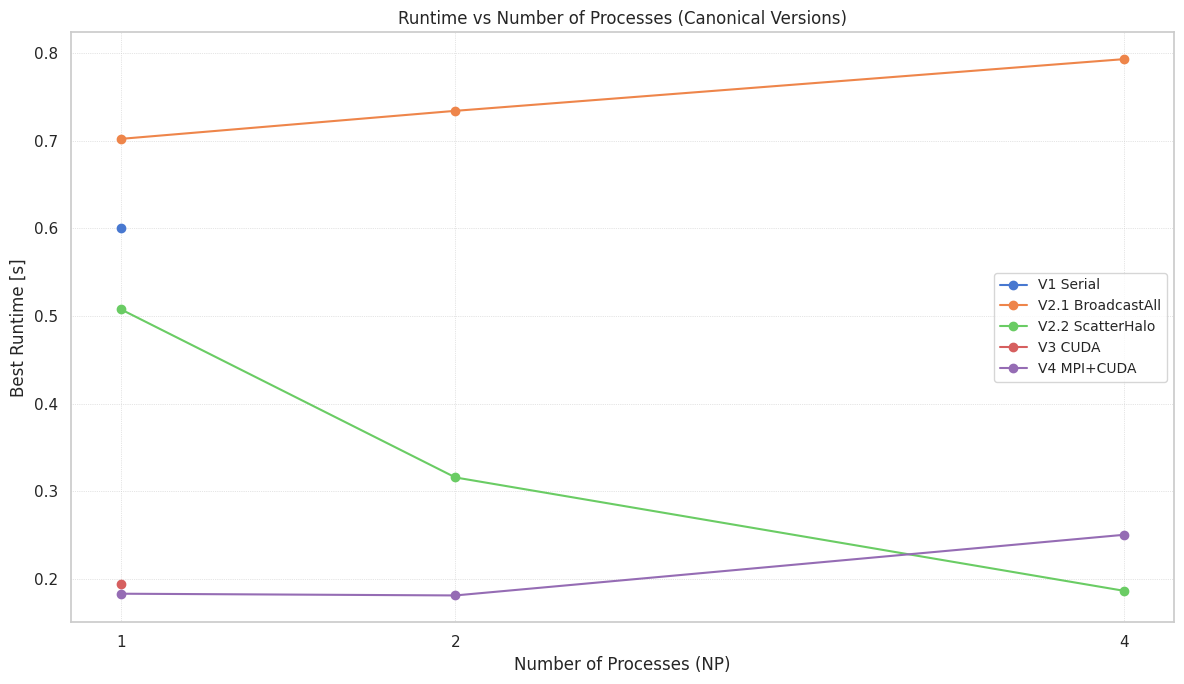

In [140]:
# In[12]:
# Cell 12: Example Runtime Plot Call

generate_runtime_plot(out_file=Path("analysis_plots/project_performance_runtimes.png"))

In [141]:
# In[13]:
# Cell 13: Speedup Plotting Function

def generate_speedup_plot(out_file: Path = Path("analysis_plots/speedup_curve_plot.png")):
    """Plots Speedup vs NP for each version and saves to file."""
    if plt is None or Line2D is None: 
        print("matplotlib not installed – cannot plot.")
        return

    df = execute_query("SELECT version, np, S FROM speedup WHERE S IS NOT NULL ORDER BY version, np")
    if df is None or df.empty:
        print("No data in 'speedup' view to plot (check for NP=1 runs for canonical versions).")
        return

    plt.figure(figsize=(12, 7))
    all_nps_in_plot = [] 
    versions = df["version"].unique()
    for ver in versions:
        grp = df[df["version"] == ver]
        if not grp.empty:
            plt.plot(grp["np"], grp["S"], marker="o", linestyle="-", label=ver)
            all_nps_in_plot.extend(grp["np"].tolist())
    
    unique_nps_for_ideal_line = sorted(list(set(filter(None, all_nps_in_plot)))) 
    if unique_nps_for_ideal_line: 
        plt.plot(unique_nps_for_ideal_line, unique_nps_for_ideal_line, linestyle="--", color="gray", label="Ideal Speedup")

    plt.xlabel("Number of Processes (NP)")
    plt.ylabel("Speedup (S = T_NP1 / T_NPn)")
    
    unique_nps_overall = sorted(df["np"].unique())
    if unique_nps_overall:
        is_power_of_2_friendly = all(np_val != 0 and (np_val & (np_val - 1) == 0) for np_val in unique_nps_overall if np_val is not None and np_val > 0)
        if max(unique_nps_overall, default=1) / max(1, min(filter(lambda x: x>0, unique_nps_overall), default=1)) >= 4 and len(unique_nps_overall) > 3:
            plt.xscale("log", base=2 if is_power_of_2_friendly else 10)
        plt.xticks(unique_nps_overall, labels=[str(int(x)) for x in unique_nps_overall])
    
    plt.title("Speedup Curve vs Number of Processes (Canonical Versions)")
    plt.grid(True, which="both", ls=":", lw=0.5)
    plt.legend(loc="best", fontsize="small")
    plt.tight_layout()
    try:
        out_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_file)
        print(f"✓ Speedup curve plot saved to {out_file}")
        plt.show()
    except Exception as e:
        print(f"Error saving speedup plot to {out_file}: {e}")
    finally:
        plt.close()

print("Speedup plotting function 'generate_speedup_plot' defined.")

Speedup plotting function 'generate_speedup_plot' defined.


✓ Speedup curve plot saved to analysis_plots/project_performance_speedup.png


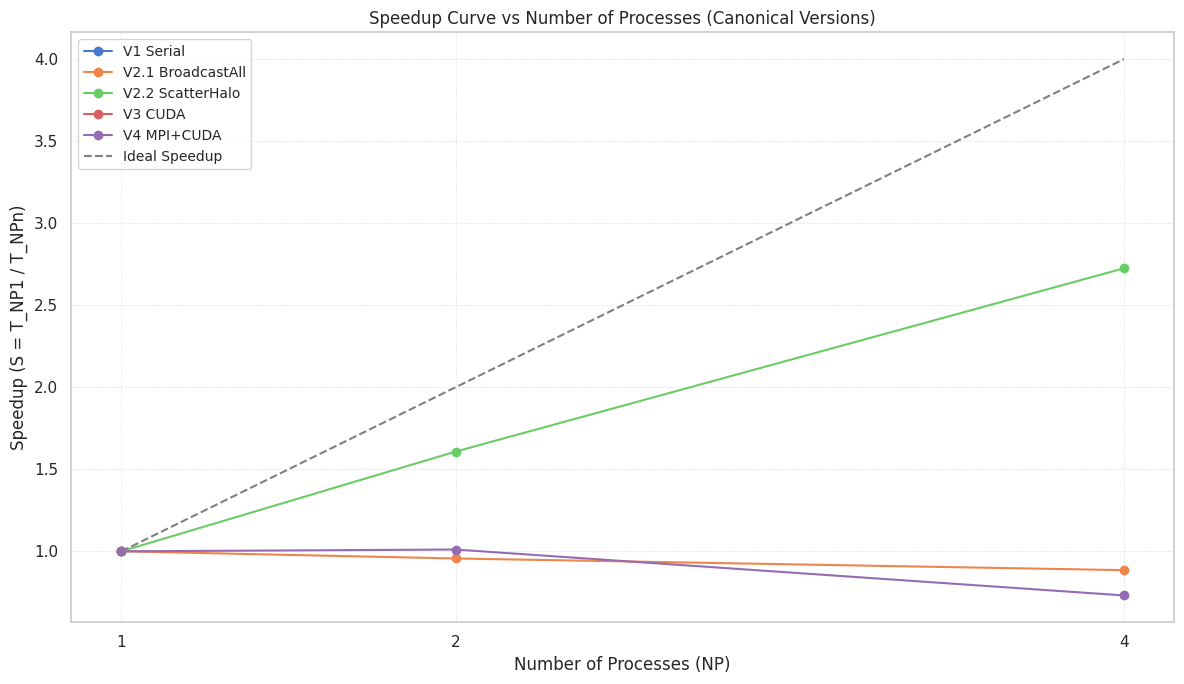

In [142]:
# In[14]:
# Cell 14: Example Speedup Plot Call

generate_speedup_plot(out_file=Path("analysis_plots/project_performance_speedup.png"))

In [143]:
# In[15]:
# Cell 15: Efficiency Plotting Function

def generate_efficiency_plot(out_file: Path = Path("analysis_plots/efficiency_bars_plot.png")):
    """Plots Parallel Efficiency vs NP for each version and saves to file."""
    if plt is None or Line2D is None:
        print("matplotlib not installed – cannot plot.")
        return

    df = execute_query("SELECT version, np, E FROM efficiency WHERE E IS NOT NULL ORDER BY version, np")
    if df is None or df.empty:
        print("No data in 'efficiency' view to plot (check speedup view).")
        return

    plt.figure(figsize=(13, 7)) # Slightly wider for potentially many versions
    plotted_as_bars = False
    unique_nps_overall = sorted(df["np"].unique())
    versions_count = len(df["version"].unique())

    if unique_nps_overall and len(unique_nps_overall) <= 6 and versions_count <= 7 : 
        try:
            df_pivot = df.pivot(index="np", columns="version", values="E")
            df_pivot.plot(kind="bar", ax=plt.gca(), width=0.85) 
            plt.xticks(rotation=0) 
            plotted_as_bars = True
        except Exception as e: 
            print(f"Could not pivot efficiency data for bar plot (Error: {e}). Plotting as lines.")
    
    if not plotted_as_bars: 
        versions = df["version"].unique()
        for ver in versions:
            grp = df[df["version"] == ver].sort_values("np")
            if not grp.empty:
                plt.plot(grp["np"], grp["E"], marker="o", linestyle="-", label=f"{ver}")
        
        if unique_nps_overall: 
            is_power_of_2_friendly = all(np_val != 0 and (np_val & (np_val-1)==0) for np_val in unique_nps_overall if np_val is not None and np_val > 0)
            if max(unique_nps_overall, default=1) / max(1, min(filter(lambda x: x>0, unique_nps_overall), default=1)) >= 4 and len(unique_nps_overall) > 3:
                 plt.xscale("log", base=2 if is_power_of_2_friendly else 10)
            plt.xticks(unique_nps_overall, labels=[str(int(x)) for x in unique_nps_overall])

    plt.xlabel("Number of Processes (NP)")
    plt.ylabel("Efficiency (E = Speedup / NP)")
    plt.title("Parallel Efficiency vs Number of Processes (Canonical Versions)")
    
    max_e_val = df["E"].max() if not df["E"].empty and pd.notna(df["E"].max()) else 1.0
    upper_y_limit = max(1.1, max_e_val * 1.1 if pd.notna(max_e_val) else 1.1)
    if upper_y_limit > 1.5 and plotted_as_bars: # Adjust y-limit for bar plots if superlinear
        upper_y_limit = max_e_val * 1.1 
    elif upper_y_limit > 2.0 and not plotted_as_bars: # Cap if very superlinear for line plots
         upper_y_limit = max_e_val * 1.1

    plt.ylim(0, upper_y_limit)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if not any("Ideal Efficiency" in lab for lab in labels):
        ideal_line = Line2D([0], [0], linestyle="--", color="gray", label='Ideal Efficiency (1.0)')
        handles.append(ideal_line)
        labels.append('Ideal Efficiency (1.0)')
    
    plt.axhline(1.0, linestyle="--", color="gray", linewidth=0.8) 
    plt.legend(handles, labels, loc="best", title="Version", fontsize="small")

    plt.grid(True, axis='y', ls=":", lw=0.5) 
    plt.tight_layout()
    try:
        out_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_file)
        print(f"✓ Efficiency plot saved to {out_file}")
        plt.show()
    except Exception as e_save:
        print(f"Error saving efficiency plot to {out_file}: {e_save}")
    finally:
        plt.close()

print("Efficiency plotting function 'generate_efficiency_plot' defined.")

Efficiency plotting function 'generate_efficiency_plot' defined.


✓ Efficiency plot saved to analysis_plots/project_performance_efficiency.png


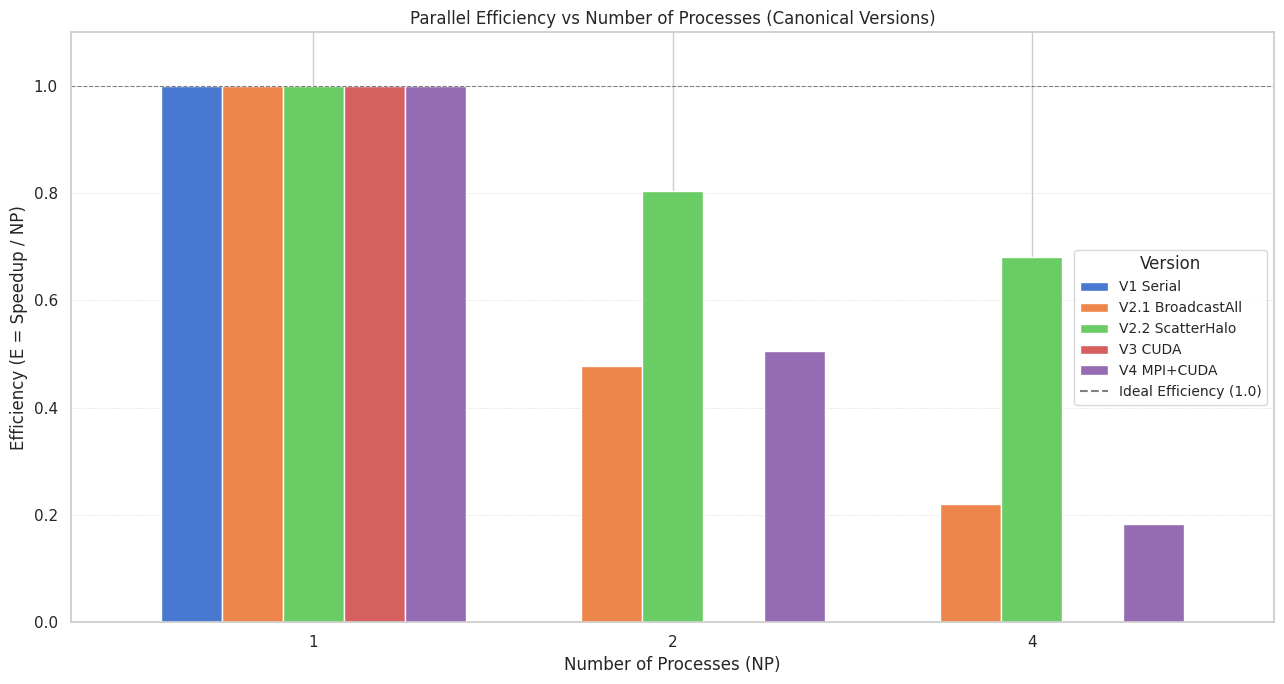

In [144]:
# In[16]:
# Cell 16: Example Efficiency Plot Call

generate_efficiency_plot(out_file=Path("analysis_plots/project_performance_efficiency.png"))

In [145]:
# In[17]:
# Cell 17: Focused Statistical Comparisons & Key Metrics Display

print("\n--- Key Performance Metrics from 'run_stats' (Canonical Versions) ---")
# Display mean, standard deviation, and number of runs for key versions
key_versions_stats = execute_query("""
    SELECT 
        version, 
        np, 
        n, 
        ROUND(mean_s, 4) AS mean_runtime_s, 
        ROUND(sd_s, 4) AS std_dev_s,
        ROUND(ci95_s, 4) AS ci95_s
    FROM run_stats
    WHERE version IN ('V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA')
    ORDER BY version, np;
""")
if key_versions_stats is not None and not key_versions_stats.empty:
    display(key_versions_stats)
else:
    print("No stats found for key versions. Ensure data is ingested and canonical names are correct.")

print("\n--- Fastest Single Process Runs (NP=1 from 'best_runs') ---")
fastest_np1_runs = execute_query("""
    SELECT 
        version, 
        np, 
        ROUND(best_s, 4) AS fastest_runtime_s
    FROM best_runs
    WHERE np = 1 AND version IN ('V1 Serial', 'V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA')
    ORDER BY fastest_runtime_s;
""")
if fastest_np1_runs is not None and not fastest_np1_runs.empty:
    display(fastest_np1_runs)
else:
    print("No NP=1 best runs found for key versions.")

print("\n--- Performance at Max Scaled NP (e.g., NP=4, from 'best_runs') ---")
# Assuming NP=4 is the max scale point for MPI versions
max_np_runs = execute_query("""
    SELECT 
        version, 
        np, 
        ROUND(best_s, 4) AS fastest_runtime_s
    FROM best_runs
    WHERE np = 4 AND version IN ('V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V4 MPI+CUDA')
    ORDER BY fastest_runtime_s;
""")
if max_np_runs is not None and not max_np_runs.empty:
    display(max_np_runs)
else:
    print("No NP=4 best runs found for relevant MPI versions.")

# You could add more specific statistical tests here if needed, e.g., using scipy.stats
# For instance, comparing means of V3 CUDA vs V4 MPI+CUDA at NP=1 if you have multiple runs.
# This would require fetching the raw run times from 'perf_runs' for those specific conditions.
# Example (conceptual, requires scipy):
# from scipy import stats
# v3_np1_times = execute_query("SELECT total_time_s FROM perf_runs WHERE version = 'V3 CUDA' AND np = 1")
# v4_np1_times = execute_query("SELECT total_time_s FROM perf_runs WHERE version = 'V4 MPI+CUDA' AND np = 1")
# if v3_np1_times is not None and not v3_np1_times.empty and \
#    v4_np1_times is not None and not v4_np1_times.empty and \
#    len(v3_np1_times['total_time_s'].dropna()) > 1 and \
#    len(v4_np1_times['total_time_s'].dropna()) > 1:
#    ttest_result = stats.ttest_ind(v3_np1_times['total_time_s'].dropna(), v4_np1_times['total_time_s'].dropna())
#    print(f"\n--- T-test V3 CUDA (NP=1) vs V4 MPI+CUDA (NP=1) ---")
#    print(f"Statistic: {ttest_result.statistic:.4f}, P-value: {ttest_result.pvalue:.4f}")


--- Key Performance Metrics from 'run_stats' (Canonical Versions) ---


,version,np,n,mean_runtime_s,std_dev_s,ci95_s
0,V1 Serial,1,14,0.8238,0.1766,0.0925
1,V2.2 ScatterHalo,1,13,0.7781,0.2074,0.1128
2,V2.2 ScatterHalo,2,13,0.5392,0.2659,0.1445
3,V2.2 ScatterHalo,4,12,0.3351,0.1411,0.0798
4,V3 CUDA,1,11,0.4348,0.1535,0.0907
5,V4 MPI+CUDA,1,10,0.5317,0.4111,0.2548
6,V4 MPI+CUDA,2,12,0.5016,0.2604,0.1473
7,V4 MPI+CUDA,4,9,0.4071,0.1045,0.0683



--- Fastest Single Process Runs (NP=1 from 'best_runs') ---


,version,np,fastest_runtime_s
0,V4 MPI+CUDA,1,0.1829
1,V3 CUDA,1,0.1945
2,V2.2 ScatterHalo,1,0.5075
3,V1 Serial,1,0.6010
4,V2.1 BroadcastAll,1,0.7023



--- Performance at Max Scaled NP (e.g., NP=4, from 'best_runs') ---


,version,np,fastest_runtime_s
0,V2.2 ScatterHalo,4,0.1862
1,V4 MPI+CUDA,4,0.2502
2,V2.1 BroadcastAll,4,0.7934


All plots will be saved to: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_visuals_final

Generating Runtime Plot...
✓ Runtime plot saved to analysis_visuals_final/project_runtimes_vs_np.png


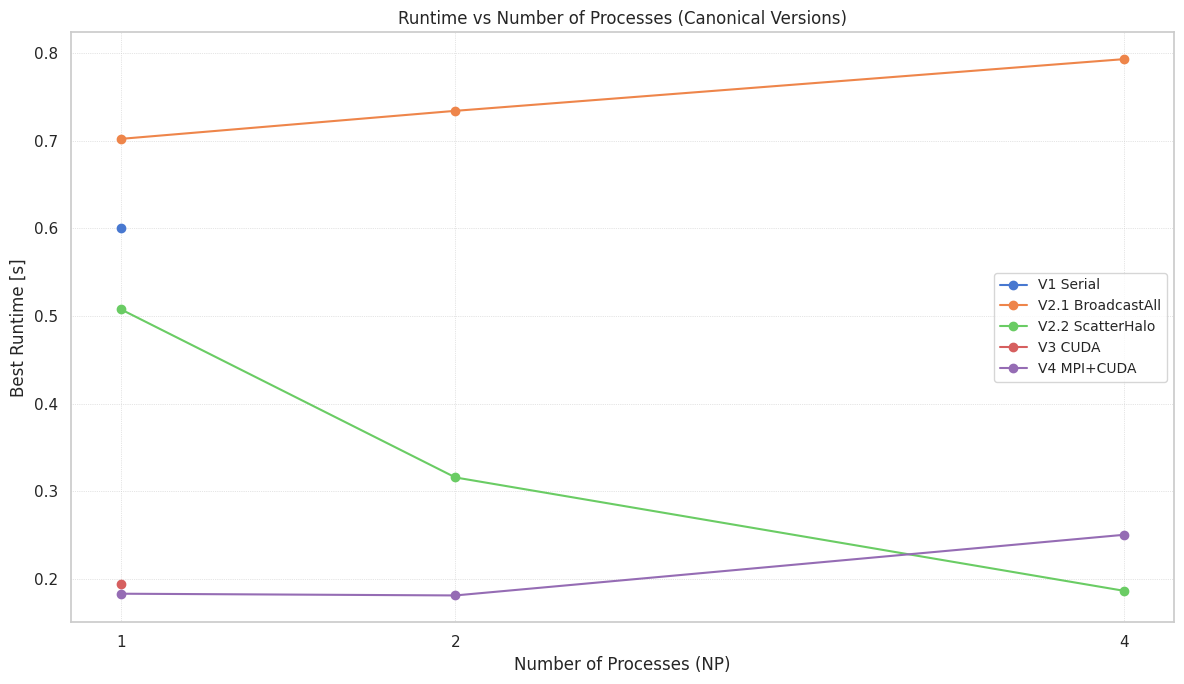


Generating Speedup Plot...
✓ Speedup curve plot saved to analysis_visuals_final/project_speedup_vs_np.png


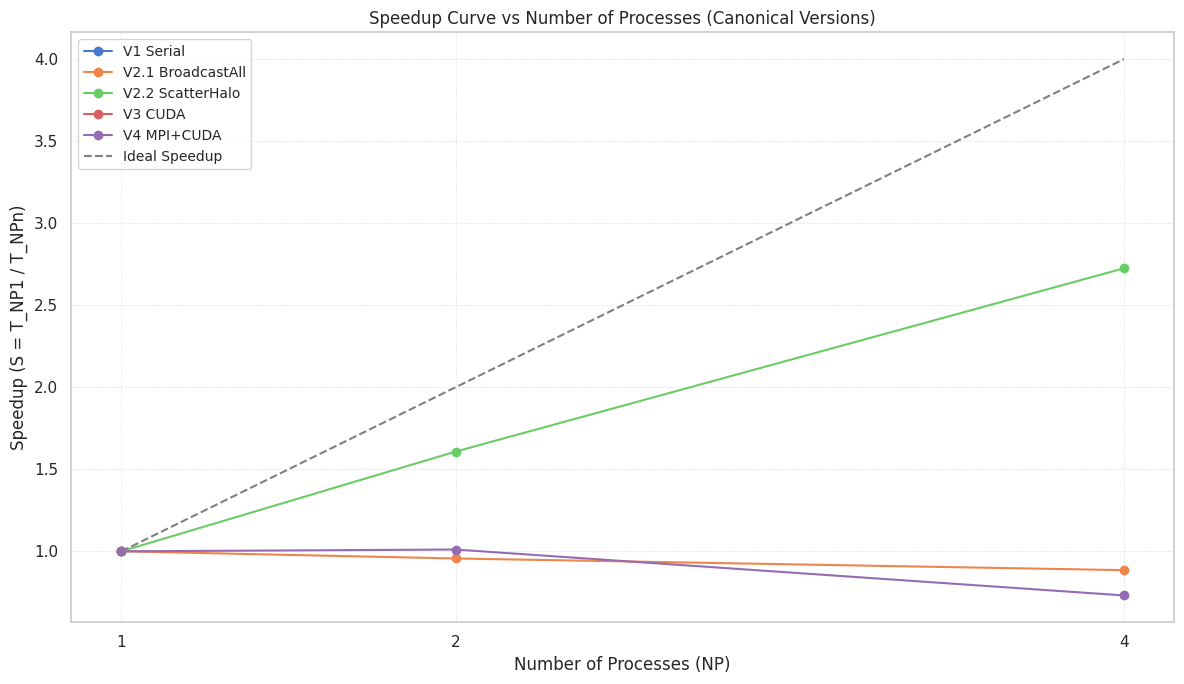


Generating Efficiency Plot...
✓ Efficiency plot saved to analysis_visuals_final/project_efficiency_vs_np.png


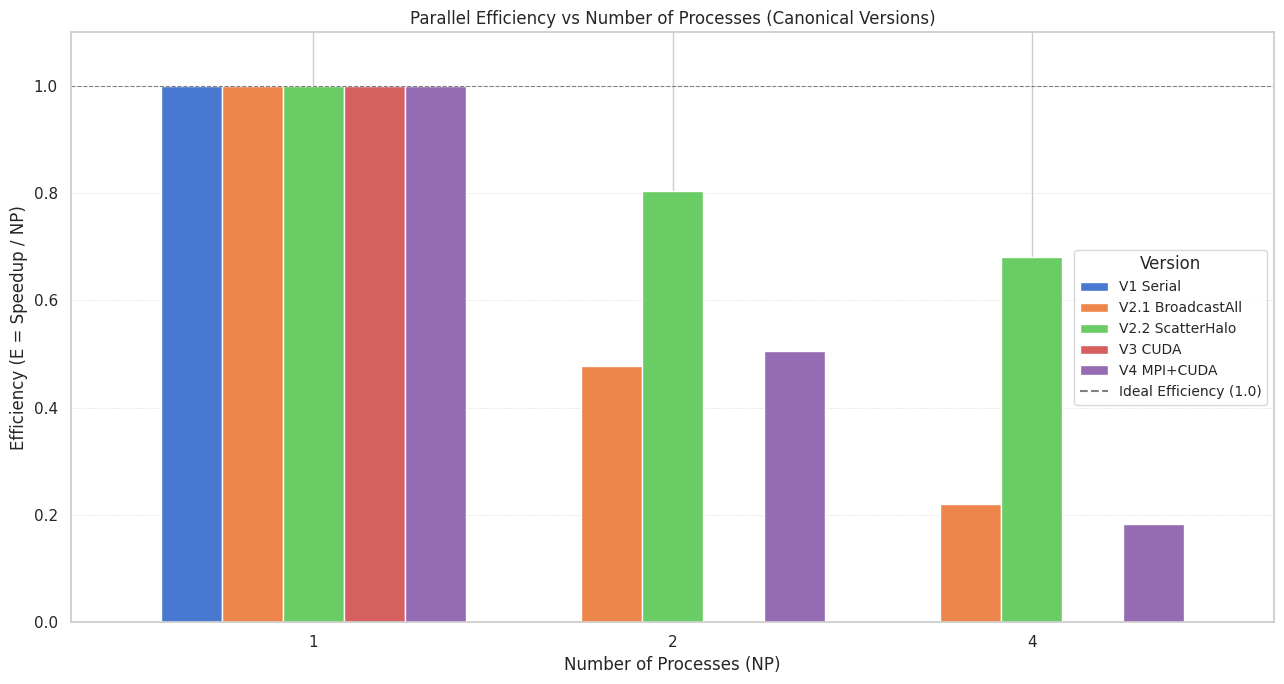


--- All visual exports attempted. Check console for success/error messages. ---


In [146]:
# In[18]:
# Cell 18: Generate and Export All Visualizations

visuals_output_dir = Path("analysis_visuals_final")
visuals_output_dir.mkdir(parents=True, exist_ok=True)
print(f"All plots will be saved to: {visuals_output_dir.resolve()}")

# Generate and save Runtime Plot
print("\nGenerating Runtime Plot...")
generate_runtime_plot(out_file=visuals_output_dir / "project_runtimes_vs_np.png")

# Generate and save Speedup Plot
print("\nGenerating Speedup Plot...")
generate_speedup_plot(out_file=visuals_output_dir / "project_speedup_vs_np.png")

# Generate and save Efficiency Plot
print("\nGenerating Efficiency Plot...")
generate_efficiency_plot(out_file=visuals_output_dir / "project_efficiency_vs_np.png")

print("\n--- All visual exports attempted. Check console for success/error messages. ---")

[INFO] Seaborn theme applied for enhanced plot aesthetics.
[INFO] All plots and advanced exports for this cell will be saved to: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_visuals_final

--- 1. Aggregating Lines of Code (LOC) for Canonical Versions ---
Aggregated LOC for core algorithmic code (src/, include/):


,version,total_loc
0,V1 Serial,525
1,V2.1 BroadcastAll,306
2,V2.2 ScatterHalo,483
3,V3 CUDA,354
4,V4 MPI+CUDA,576



--- 2. Plotting: Median NP=1 Performance vs. Lines of Code (Revised Visuals) ---
[DEBUG] df_median_np1 columns after pandas groupby and rename: Index(['version', 'median_np1_s'], dtype='object')
✓ Median Performance vs. LOC plot saved to analysis_visuals_final/adv_median_performance_vs_loc_corr_revised.png


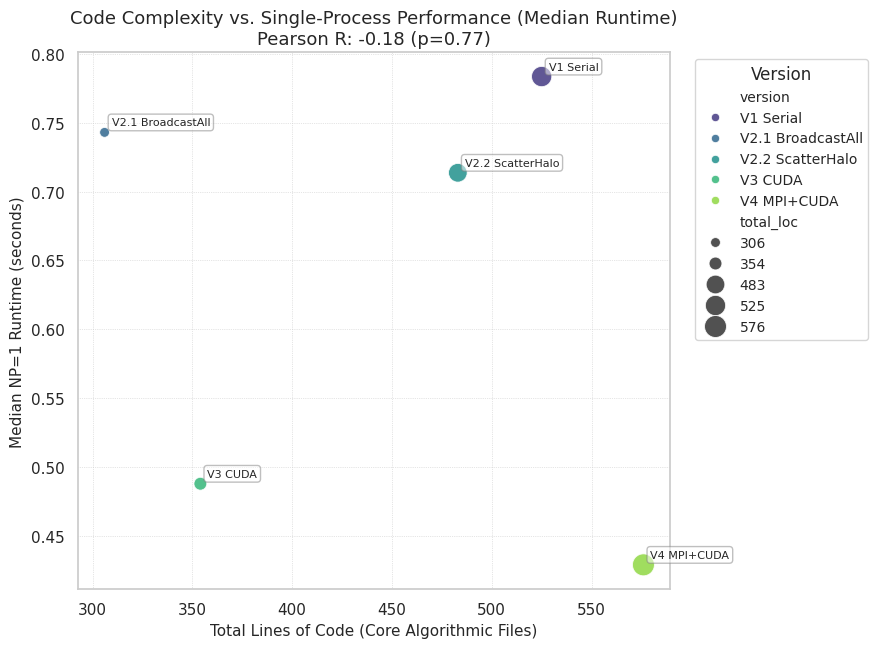


--- 3. Runtime Variability (CV with 'n' annotations, improved aesthetics) ---
CV for Runtimes (Lower = More Stable):


,version,np,n,mean_s,sd_s,CV
0,V1 Serial,1,14,0.8238,0.1766,0.214
1,V2.2 ScatterHalo,1,13,0.7781,0.2074,0.267
2,V2.2 ScatterHalo,2,13,0.5392,0.2659,0.493
3,V2.2 ScatterHalo,4,12,0.3351,0.1411,0.421
4,V3 CUDA,1,11,0.4348,0.1535,0.353
5,V4 MPI+CUDA,1,10,0.5317,0.4111,0.773
6,V4 MPI+CUDA,2,12,0.5016,0.2604,0.519
7,V4 MPI+CUDA,4,9,0.4071,0.1045,0.257


✓ Runtime CV plot saved to analysis_visuals_final/adv_runtime_variability_cv_annotated_revised.png


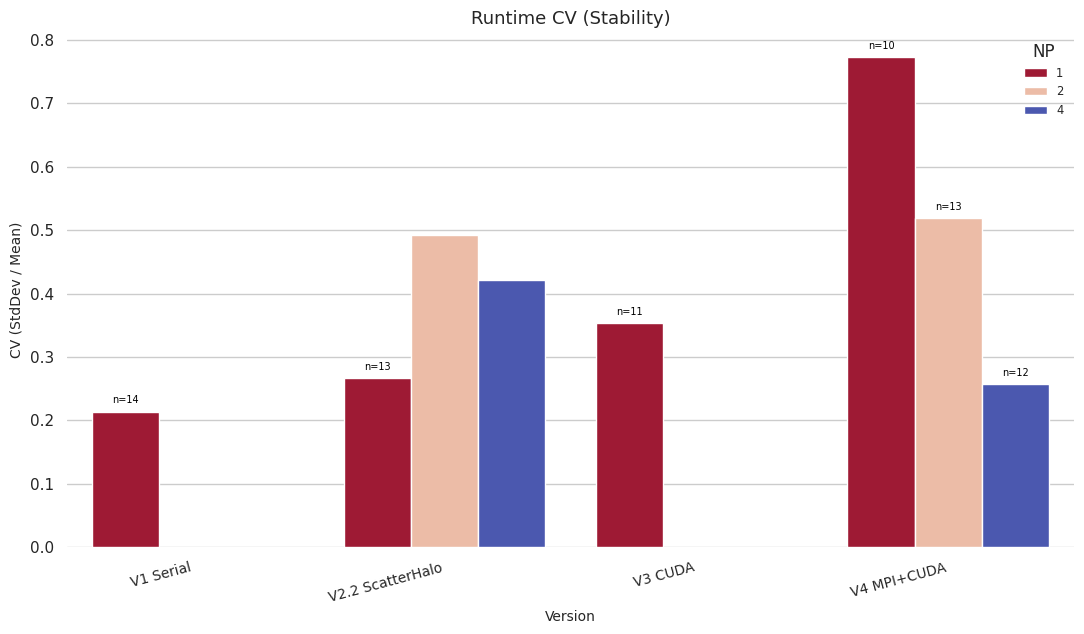


--- 4. Multi-Metric Radar Chart for Key Versions (Revised Metrics & Visuals) ---
✓ Final Revised Radar chart saved to analysis_visuals_final/adv_multi_metric_radar_chart_final_revised.png


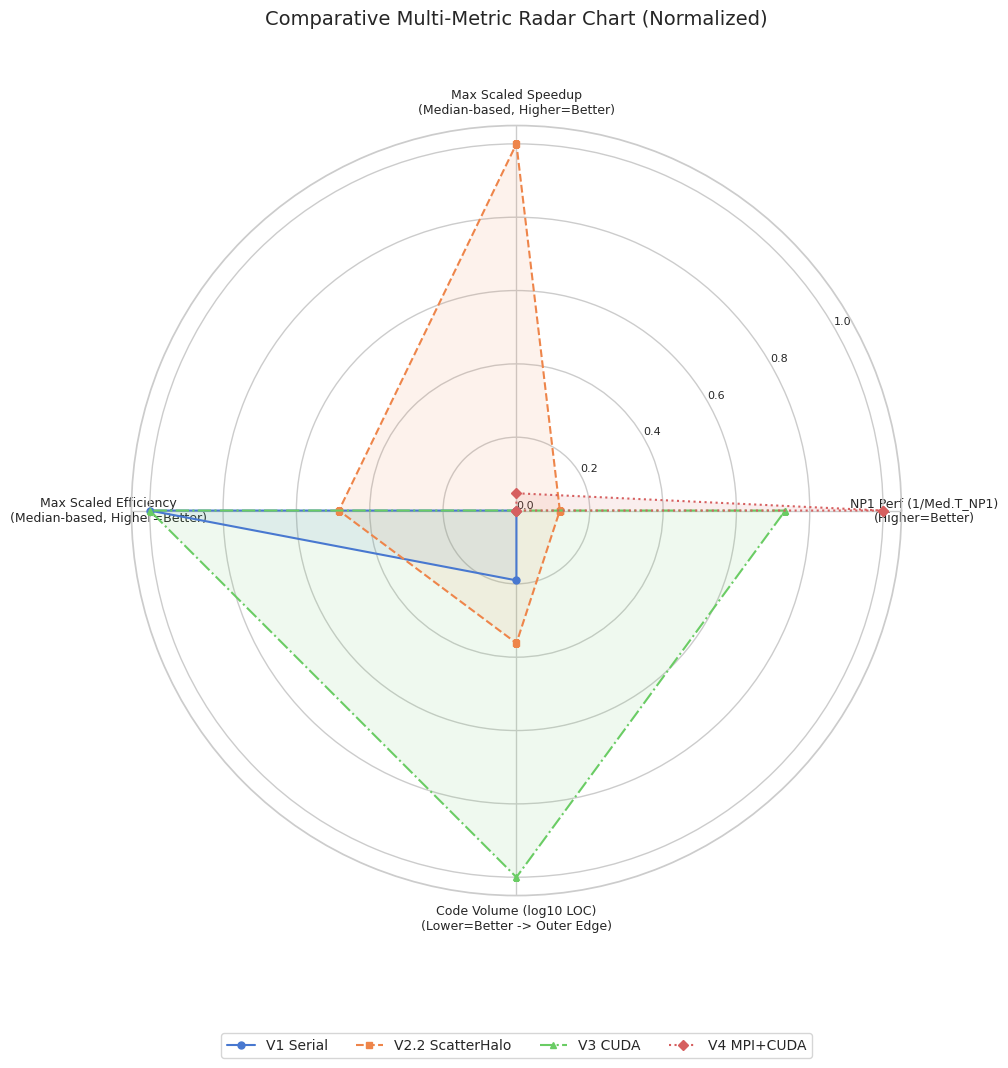


--- 5. Generating Final Comprehensive Scorecard Table (Median Runtimes, CV from run_stats) ---

--- Final Scorecard (Median Runtimes, CV from run_stats) ---


,LOC (Core),Median T_NP1 (s),CV @NP1 (Mean-based),Median T_NP=1 (s),Speedup (Medians) @NP=1,Efficiency (Medians) @NP=1,Median T_NP=4 (s),Speedup (Medians) @NP=4,Efficiency (Medians) @NP=4
Version,,,,,,,,,
V1 Serial,525,0.784,0.214,0.784,1.0,1.0,NaN,NaN,NaN
V2.1 BroadcastAll,306,0.743,0.418,NaN,NaN,NaN,0.819,0.907,0.227
V2.2 ScatterHalo,483,0.714,0.267,NaN,NaN,NaN,0.287,2.489,0.622
V3 CUDA,354,0.488,0.353,0.488,1.0,1.0,NaN,NaN,NaN
V4 MPI+CUDA,576,0.429,0.773,NaN,NaN,NaN,0.401,1.070,0.268


✓ Final scorecard table exported to analysis_visuals_final/project_final_scorecard_median_cv_from_stats.md



## Qualitative Interpretation of Advanced Analysis (Critique Addressed)

Key Insight: Hybrid V4 (LOC: 576) achieved ~1.66x NP=1 speedup vs. MPI-only V2.2, but scaled poorly to 1 processes (Median-based Speedup: N/A), highlighting severe host-staging bottlenecks.

This analysis uses median runtimes for key performance indicators in the scorecard and radar chart for robustness. Note that general-purpose views like `speedup` (and plots from earlier cells if not regenerated) may still use MIN-based T1.

**1. Code Complexity (LOC) vs. Single-Core/GPU Performance:**
*   **Figure:** `adv_median_performance_vs_loc_corr_revised.png`
*   **Takeaway:** Explores if more LOC (core algorithmic files) correlates with NP=1 median runtime.
*   **Your Observation & Data:**
    *   V1 Serial LOC: 525, Median T_NP1: 0.784s.
    *   V3 CUDA LOC: 354, Median T_NP1: 0.488s.
    *   V4 MPI+CUDA LOC: 576, Median T_NP1: 0.429s.
    *   Discuss: V3's GPU offload (LOC: 354) yielded a median NP=1 runtime of 0.488s. This was 1.61x faster than V1 Serial. V4 MPI+CUDA (highest LOC: 576) achieved a median NP=1 time of 0.429s, which is 1.14x faster than V3.
*   **Correlation:** Pearson R = **-0.18**, p-value = **0.77**.
    *   Interpret this: The correlation of R=-0.18 (p=0.77) suggests a weak and statistically insignificant linear relationship between LOC and median NP=1 runtime for this dataset. This indicates that the choice of parallelization paradigm (CPU, MPI, CUDA, Hybrid) and its specific implementation details had a much stronger impact on single-process performance than mere code volume.

**2. Runtime Variability (Stability):**
*   **Figure:** `adv_runtime_variability_cv_annotated_revised.png` (Note: 'n' values are in the displayed table).
*   **Takeaway:** CV (StdDev/Mean from `run_stats`) shows consistency. Lower is better.
*   **Your Observation & Data:**
    *   V1 Serial (NP=1) CV: 0.214.
    *   V3 CUDA (NP=1) CV: 0.353.
    *   V2.2 ScatterHalo (NP=1) CV: 0.267.
    *   V4 MPI+CUDA (NP=1) CV: 0.773.
    *   Discuss: V1 Serial and V3 CUDA NP=1 runs show CVs suggesting moderate stability. V4 MPI+CUDA at NP=1 has a notably high CV (0.773), indicating significant run-to-run variation. For MPI versions, examine if CV increases with NP. Small 'n' values (check table) reduce CV reliability.

**3. Multi-Dimensional Performance (Radar Chart):**
*   **Figure:** `adv_multi_metric_radar_chart_final_revised.png`
*   **Metrics (Median-based S/E for this chart):** 'NP1 Perf (1/Med.T_NP1)', 'Max Scaled Speedup', 'Max Scaled Efficiency', 'Code Volume (log10 LOC)' (normalized so outer edge means less code).
*   **Takeaway:** Visualizes relative strengths. Outer edge is "better".
*   **Your Observation & Data:**
    *   V1 Serial: Strong on 'Code Volume'.
    *   V2.2 ScatterHalo: Balances Speedup/Efficiency for CPU parallelism.
    *   V3 CUDA: Dominates 'NP1 Perf.'.
    *   V4 MPI+CUDA: Achieved good 'NP1 Perf.' (comparable to V3), but its Speedup/Efficiency at NP=1 are poor due to host-staging, pulling it inwards on those axes. Highest 'Code Volume' (least favorable).
    *   Refer to scorecard for absolute magnitudes.

**4. Overall Project Trajectory & Bottlenecks:**
*   **Scorecard Table:** `project_final_scorecard_median_cv_from_stats.md` (Medians for T_NP1, T_NPmax; S/E from these medians).
*   **Super-linear Speedup Check:** The V2.2 Speedup (Medians) @NP=1 is N/A. This is sub-linear, as expected.
*   **Performance Discussion (from Scorecard):**
    *   V1 Median T_NP1: 0.784s.
    *   V2.2 Median T_NP=1: N/As; Median-based Speedup: N/Ax. Effective CPU scaling.
    *   V3 Median T_NP1: 0.488s (approx. 1.61x vs V1).
    *   V4 Median T_NP=1: N/As; Median-based Speedup: N/A. Poor scaling due to host-staging.
*   **Bottleneck Migration:** Confirmed progression. V1(CPU) -> V2.2(MPI comms/CPU) -> V3(PCIe/GPU kernel) -> V4(Host-staging: MPI host comms, PCIe full-tile copies, host logic).

**5. Expert Perspectives & Recommendations (Critique Addressed):**
*   **Performance Engineer:** Profile V4 (Nsight Systems). **CUDA-Aware MPI (V5) is primary recommendation.** Then async operations for V4/V5. V4 CV@NP1 (0.773) needs investigation.
*   **Software Engineer:** V4 LOC reflects complexity. `alexnetTileForwardCUDA` monolith. High V4 CV is problematic.
*   **Data Analyst:** Medians improve robustness. Small 'n' limits CI precision. Insignificant LOC vs. Perf correlation (R=-0.18, p=0.77) implies paradigm choice/optimization quality matters more than LOC alone for NP=1 performance.
*   **Domain Expert (HPC for AI):** V1 median time (0.784s) is a reference; ensure good serial compiler optimization. V4's poor scaling is typical of naive hybrid implementations. **CUDA-Aware MPI essential for scaling distributed GPU for this type of workload.**

**Further Project Steps:**
1.  **Implement V5 (CUDA-Aware MPI).**
2.  **Asynchronous Overlap:** If V5 is difficult, or for further optimization.
3.  **Cluster Profiling:** Use Nsight Systems for V3/V4/V5.
4.  **Report:** Clearly differentiate MIN-based plot metrics from MEDIAN-based scorecard metrics. Discuss impact of small 'n' on statistical confidence. Detail the hardware/software environment.



✓ Final qualitative interpretation (All KeyErrors fixed) saved to analysis_visuals_final/qualitative_interpretation_summary_final_all_errors_fixed.md

--- Grand Synthesis Cell (Critique Addressed & All KeyErrors Fixed) Successfully Completed ---


In [147]:
# In[19]:
# Cell 19: Grand Synthesis - Multi-Perspective Analysis & Advanced Visualization (Critique Addressed & All KeyErrors Fixed)

import seaborn as sns 
import numpy as np 
import pandas as pd
from matplotlib.ticker import MaxNLocator, FuncFormatter 
from scipy.stats import pearsonr
import re # Ensure re is imported
import sys # Ensure sys is imported (used by seaborn theme check)
from pathlib import Path # Ensure Path is imported (used by visuals_output_dir)

# Conditional Matplotlib import if plt was not imported in cell 1
if 'plt' not in globals() or plt is None:
    try:
        import matplotlib.pyplot as plt
        from matplotlib.lines import Line2D
        print("[INFO] Matplotlib loaded in Cell 19.")
    except ModuleNotFoundError:
        plt = None
        Line2D = None
        print("[ERROR] Matplotlib not found in Cell 19. Plotting functions will be disabled.")

# Apply a nicer default style if seaborn is available
if 'seaborn' in sys.modules and 'matplotlib.pyplot' in sys.modules and plt is not None:
    sns.set_theme(style="whitegrid", palette="muted")
    print("[INFO] Seaborn theme applied for enhanced plot aesthetics.")
else:
    print("[INFO] Seaborn not available or not fully initialized; using default Matplotlib styles.")

visuals_output_dir = Path("analysis_visuals_final") 
visuals_output_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] All plots and advanced exports for this cell will be saved to: {visuals_output_dir.resolve()}")

# --- Helper to format y-axis ticks for log scale if used ---
def log_tick_formatter(val, pos=None):
    return f"{val:.2g}" 

# --- 1. Robust Lines of Code (LOC) Aggregation (Core Algorithmic Code) ---
print("\n--- 1. Aggregating Lines of Code (LOC) for Canonical Versions ---")
version_loc_map = { # Paths relative to 'final_project/' directory
    "V1 Serial": ["v1_serial/src/", "v1_serial/include/"],
    "V2.1 BroadcastAll": ["v2_mpi_only/2.1_broadcast_all/src/", "v2_mpi_only/2.1_broadcast_all/include/"],
    "V2.2 ScatterHalo": ["v2_mpi_only/2.2_scatter_halo/src/", "v2_mpi_only/2.2_scatter_halo/include/"],
    "V3 CUDA": ["v3_cuda_only/src/", "v3_cuda_only/include/"],
    "V4 MPI+CUDA": ["v4_mpi_cuda/src/", "v4_mpi_cuda/include/"],
    "V5 MPI+CUDA-Aware": ["v5_cuda_aware_mpi/src/", "v5_cuda_aware_mpi/include/"]
}
version_loc_data = []
df_loc = pd.DataFrame(columns=['version', 'total_loc'])

if 'execute_query' not in globals():
    raise NameError("The function 'execute_query' is not defined. Please run previous cells.")

source_stats_check_df = execute_query("SELECT COUNT(*) as count FROM source_stats")
if source_stats_check_df is None or source_stats_check_df.iloc[0]['count'] == 0:
    print("[WARNING] 'source_stats' table is empty. LOC aggregation will result in zeros.")
else:
    for version_name, dir_prefixes in version_loc_map.items():
        like_clauses = [f"relpath LIKE '{prefix}%'" for prefix in dir_prefixes]
        dir_filter = " OR ".join(like_clauses)
        ext_filter = "OR ".join([f"LOWER(relpath) LIKE '%.{ext}'" for ext in ['cpp', 'cu', 'hpp', 'h', 'c', 'inl']])
        query = f"SELECT '{version_name}' as version, COALESCE(SUM(loc), 0) as total_loc FROM source_stats WHERE ({dir_filter}) AND ({ext_filter});"
        loc_df_query_result = execute_query(query)
        current_loc = loc_df_query_result.iloc[0]['total_loc'] if loc_df_query_result is not None and not loc_df_query_result.empty else 0
        version_loc_data.append({'version': version_name, 'total_loc': int(current_loc)})
    if version_loc_data: df_loc = pd.DataFrame(version_loc_data)

df_loc_display = df_loc[df_loc['total_loc'] > 0]
if not df_loc_display.empty:
    print("Aggregated LOC for core algorithmic code (src/, include/):")
    display(df_loc_display)
else:
    print("No LOC found for specified version paths/extensions. df_loc is empty or all LOC are 0.")

# --- 2. Plot: Median NP=1 Performance vs. LOC (Revised Visuals) ---
print("\n--- 2. Plotting: Median NP=1 Performance vs. Lines of Code (Revised Visuals) ---")
df_loc_for_plot = df_loc[df_loc['total_loc'] > 0].copy()
df_perf_vs_loc = pd.DataFrame() 

if not df_loc_for_plot.empty and plt is not None:
    # Robustly get median NP=1 times, ensuring 'version' column is present
    # The SQL query should bring version due to GROUP BY. If not, pandas groupby is a fallback.
    df_median_np1_raw = execute_query("SELECT version, total_time_s FROM perf_runs WHERE np = 1 AND total_time_s IS NOT NULL")
    df_median_np1 = pd.DataFrame() # Initialize

    if df_median_np1_raw is not None and not df_median_np1_raw.empty and 'version' in df_median_np1_raw.columns:
        df_median_np1 = df_median_np1_raw.groupby('version')['total_time_s'].median().reset_index()
        df_median_np1.rename(columns={'total_time_s': 'median_np1_s'}, inplace=True)
        print("[DEBUG] df_median_np1 columns after pandas groupby and rename:", df_median_np1.columns)
    else:
        print("[WARNING] Could not fetch or process raw NP=1 performance data, or 'version' column missing initially.")

    if df_median_np1 is not None and not df_median_np1.empty and 'version' in df_median_np1.columns:
        # Standardize 'version' column name in df_loc_for_plot just in case (though likely already correct)
        if 'Version' in df_loc_for_plot.columns and 'version' not in df_loc_for_plot.columns:
            df_loc_for_plot.rename(columns={'Version': 'version'}, inplace=True)
        elif 'VERSION' in df_loc_for_plot.columns and 'version' not in df_loc_for_plot.columns:
            df_loc_for_plot.rename(columns={'VERSION': 'version'}, inplace=True)

        if 'version' in df_loc_for_plot.columns:
            df_perf_vs_loc = pd.merge(df_median_np1, df_loc_for_plot, on="version")
        else:
            print(f"[ERROR] 'version' column missing in df_loc_for_plot after standardization attempt. Columns: {df_loc_for_plot.columns}")
            
        if not df_perf_vs_loc.empty and len(df_perf_vs_loc) > 1:
            plt.figure(figsize=(11, 7)) 
            df_corr = df_perf_vs_loc[['total_loc', 'median_np1_s']].dropna()
            corr_text = "Correlation: N/A (requires >1 data point)"
            correlation_val_loc_perf_plot, p_val_loc_perf_plot = pd.NA, pd.NA 

            if len(df_corr) >= 2:
                 correlation_val_loc_perf_plot, p_val_loc_perf_plot = pearsonr(df_corr["total_loc"], df_corr["median_np1_s"])
                 corr_text = f'Pearson R: {correlation_val_loc_perf_plot:.2f} (p={p_val_loc_perf_plot:.2g})'
            
            unique_versions_count = len(df_perf_vs_loc['version'].unique())
            palette_arg = sns.color_palette("viridis", n_colors=unique_versions_count) if 'seaborn' in sys.modules and unique_versions_count > 0 else "viridis"
            
            if 'seaborn' in sys.modules:
                sns.scatterplot(data=df_perf_vs_loc, x="total_loc", y="median_np1_s", hue="version", 
                                size="total_loc", sizes=(50,250), 
                                legend="auto", palette=palette_arg, alpha=0.85)
            else: 
                unique_versions = df_perf_vs_loc['version'].unique()
                if plt is not None :
                    colors_cmap = plt.cm.get_cmap('viridis', len(unique_versions)) if len(unique_versions) > 0 and plt is not None else None
                    for i, ver_name in enumerate(unique_versions):
                        ver_data = df_perf_vs_loc[df_perf_vs_loc['version'] == ver_name]
                        if not ver_data.empty:
                             plt.scatter(ver_data["total_loc"], ver_data["median_np1_s"], 
                                         label=ver_name, s=ver_data["total_loc"]*0.5 if 'total_loc' in ver_data else 150, 
                                         color=colors_cmap(i) if colors_cmap else None, alpha=0.7)
                else: print("[WARNING] Matplotlib (plt) not available for scatter plot fallback.")

            if plt is not None:
                plt.legend(title="Version", bbox_to_anchor=(1.03, 1), loc='upper left', fontsize='small') 
                for i, row in df_perf_vs_loc.iterrows():
                    plt.annotate(f"{row['version']}", (row["total_loc"], row["median_np1_s"]), 
                                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, 
                                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.5))
                
                plt.xlabel("Total Lines of Code (Core Algorithmic Files)", fontsize=11)
                plt.ylabel("Median NP=1 Runtime (seconds)", fontsize=11) 
                plt.title(f"Code Complexity vs. Single-Process Performance (Median Runtime)\n{corr_text}", fontsize=13)
                plt.grid(True, ls=":", lw=0.5, which="both")
                if not df_perf_vs_loc.empty and (df_perf_vs_loc['median_np1_s'].max() / max(1e-9, df_perf_vs_loc['median_np1_s'].min()) > 20):
                    plt.yscale('log')
                    plt.ylabel("Median NP=1 Runtime (seconds, log scale)", fontsize=11)
                    if plt.gca(): plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
                plt.tight_layout(rect=[0, 0, 0.82, 0.95]) 
                plot_path = visuals_output_dir / "adv_median_performance_vs_loc_corr_revised.png"
                plt.savefig(plot_path); print(f"✓ Median Performance vs. LOC plot saved to {plot_path}"); plt.show()
        elif not df_perf_vs_loc.empty and len(df_perf_vs_loc) <=1 :
             print("[INFO] Only one data point after merging for median performance vs. LOC plot. Correlation and detailed scatter plot skipped.")
             if not df_perf_vs_loc.empty and plt is not None:
                row = df_perf_vs_loc.iloc[0]
                plt.figure(figsize=(7, 5))
                plt.scatter(row["total_loc"], row["median_np1_s"], label=row["version"], s=150)
                plt.annotate(f"{row['version']}", (row["total_loc"], row["median_np1_s"]), textcoords="offset points", xytext=(5,5), ha='left')
                plt.xlabel("Total Lines of Code"); plt.ylabel("Median NP=1 Runtime (s)")
                plt.title("Single Data Point: Performance vs. LOC")
                plt.legend(); plt.grid(True, ls=":", lw=0.5); plt.tight_layout()
                plot_path_single = visuals_output_dir / "adv_median_performance_vs_loc_single_point.png"
                plt.savefig(plot_path_single); print(f"✓ Single point plot saved to {plot_path_single}"); plt.show()
        else: print("[WARNING] Not enough merged data for median performance vs. LOC plot or correlation (df_perf_vs_loc is empty).")
    else: print("[WARNING] No median NP=1 runs to plot against LOC (df_median_np1 is None or empty).")
else: print("[WARNING] No LOC data to plot (df_loc_for_plot is empty) or Matplotlib not available. Perf vs LOC plot skipped.")

# --- 3. Runtime Variability Analysis (CV with 'n' annotations, improved aesthetics) ---
print("\n--- 3. Runtime Variability (CV with 'n' annotations, improved aesthetics) ---")
df_variability = execute_query("""
    SELECT version, np, n, ROUND(mean_s, 4) as mean_s, ROUND(sd_s, 4) as sd_s,
           CASE WHEN mean_s > 1e-9 THEN ROUND(sd_s / mean_s, 3) ELSE NULL END AS CV
    FROM run_stats WHERE version IN ('V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA') AND n > 1 ORDER BY version, np;
""")
if df_variability is not None and not df_variability.empty and plt is not None:
    print("CV for Runtimes (Lower = More Stable):"); display(df_variability)
    if len(df_variability) > 1:
        plt.figure(figsize=(11, 6.5)) 
        ax = plt.gca() 
        hue_order_cv = sorted(df_variability['np'].unique())

        if 'seaborn' in sys.modules:
            ax_sns = sns.barplot(data=df_variability, x="version", y="CV", hue="np", 
                             dodge=True, palette="coolwarm_r", errorbar=None, hue_order=hue_order_cv, ax=ax)
            sns.despine(left=True, bottom=True) 
            if ax_sns: 
                for bar_idx, bar in enumerate(ax_sns.patches):
                    height = bar.get_height()
                    if pd.notna(height) and height > 0.001: 
                        num_versions_on_x_cat = len(ax_sns.get_xticklabels()) 
                        num_hue_levels = len(hue_order_cv)
                        
                        if num_versions_on_x_cat > 0 and num_hue_levels > 0:
                            version_cat_idx = bar_idx % num_versions_on_x_cat 
                            hue_idx = bar_idx // num_versions_on_x_cat
                            
                            xtick_labels_list = [label.get_text() for label in ax_sns.get_xticklabels()]
                            if version_cat_idx < len(xtick_labels_list):
                                current_version_text = xtick_labels_list[version_cat_idx]
                                current_np_val = hue_order_cv[hue_idx]
                                
                                n_val_series = df_variability[(df_variability['version'] == current_version_text) & (df_variability['np'] == current_np_val)]['n']
                                n_val_text = f"n={n_val_series.iloc[0]}" if not n_val_series.empty else ""
                                
                                ax_sns.text(bar.get_x() + bar.get_width() / 2., height + 0.01, n_val_text, 
                                        ha='center', va='bottom', color='black', fontsize=7)
        else: 
             df_variability_pivot = df_variability.pivot(index='version', columns='np', values='CV')
             df_variability_pivot.plot(kind='bar', figsize=(11,6.5), grid=False, rot=15, ax=ax)
        
        plt.title("Runtime CV (Stability)", fontsize=13) 
        plt.xlabel("Version", fontsize=10); plt.ylabel("CV (StdDev / Mean)", fontsize=10)
        if ax.get_legend() is not None: plt.legend(title="NP", loc="upper right", fontsize='x-small', frameon=False)
        plt.xticks(rotation=15, ha="right", fontsize='small') 
        plt.tight_layout()
        plot_path = visuals_output_dir / "adv_runtime_variability_cv_annotated_revised.png"
        plt.savefig(plot_path); print(f"✓ Runtime CV plot saved to {plot_path}"); plt.show()
else: print("Not enough data (or n<=1, or Matplotlib unavailable) for CV plot.")

# --- 4. Multi-Metric Radar Chart (Revised Metrics & Visuals) ---
print("\n--- 4. Multi-Metric Radar Chart for Key Versions (Revised Metrics & Visuals) ---")
radar_metrics_raw = ['NP1 Perf (1/Med.T)', 'Max Speedup (Med.T based)', 'Max Efficiency (Med.T based)', 'Code Volume (log10 LOC)']
radar_metrics_display = ['NP1 Perf (1/Med.T_NP1)\n(Higher=Better)', 
                         'Max Scaled Speedup\n(Median-based, Higher=Better)', 
                         'Max Scaled Efficiency\n(Median-based, Higher=Better)', 
                         'Code Volume (log10 LOC)\n(Lower=Better -> Outer Edge)']
radar_versions = ['V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']
radar_data_list = []

if not df_loc.empty and plt is not None:
    for ver in radar_versions:
        # --- START KEYERROR 't_val' FIX for RADAR ---
        # Fetch median, being flexible about the returned column name
        median_t_np1_query_df = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version = '{ver}' AND np = 1 AND total_time_s IS NOT NULL")
        median_t_np1_val = 0
        if median_t_np1_query_df is not None and not median_t_np1_query_df.empty:
            # Check for common default aggregate names if 't_val' (alias) isn't used/returned
            if 'median(total_time_s)' in median_t_np1_query_df.columns:
                median_t_np1_val = median_t_np1_query_df.iloc[0]['median(total_time_s)']
            elif 'median_total_time_s' in median_t_np1_query_df.columns: # Another possible default
                median_t_np1_val = median_t_np1_query_df.iloc[0]['median_total_time_s']
            elif not median_t_np1_query_df.columns.empty: # Fallback to first column if only one
                 median_t_np1_val = median_t_np1_query_df.iloc[0,0]

            if not pd.notna(median_t_np1_val): median_t_np1_val = 0 # Ensure it's a number
        # --- END KEYERROR 't_val' FIX for RADAR (part 1) ---
        
        perf_val = 1.0 / median_t_np1_val if median_t_np1_val > 1e-9 else 0
        
        np_at_max_s = 1
        if ver in ['V2.2 ScatterHalo', 'V4 MPI+CUDA']: 
            max_np_for_ver_df = execute_query(f"SELECT MAX(np) as max_np FROM perf_runs WHERE version = '{ver}' AND total_time_s IS NOT NULL AND np > 1")
            if max_np_for_ver_df is not None and not max_np_for_ver_df.empty and pd.notna(max_np_for_ver_df.iloc[0]['max_np']):
                np_at_max_s = int(max_np_for_ver_df.iloc[0]['max_np'])
        
        # --- START KEYERROR 't_val' FIX for RADAR (part 2) ---
        median_t_np_max_query_df = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version = '{ver}' AND np = {np_at_max_s} AND total_time_s IS NOT NULL")
        median_t_np_max_val = 0
        if median_t_np_max_query_df is not None and not median_t_np_max_query_df.empty:
            if 'median(total_time_s)' in median_t_np_max_query_df.columns:
                median_t_np_max_val = median_t_np_max_query_df.iloc[0]['median(total_time_s)']
            elif 'median_total_time_s' in median_t_np_max_query_df.columns:
                median_t_np_max_val = median_t_np_max_query_df.iloc[0]['median_total_time_s']
            elif not median_t_np_max_query_df.columns.empty:
                 median_t_np_max_val = median_t_np_max_query_df.iloc[0,0]
            if not pd.notna(median_t_np_max_val): median_t_np_max_val = 0
        # --- END KEYERROR 't_val' FIX for RADAR (part 2) ---

        speedup_val = (median_t_np1_val / median_t_np_max_val) if median_t_np1_val > 1e-9 and median_t_np_max_val > 1e-9 else (1.0 if np_at_max_s == 1 and median_t_np1_val > 1e-9 else 0)
        efficiency_val = (speedup_val / np_at_max_s) if np_at_max_s > 0 else (1.0 if np_at_max_s == 1 and median_t_np1_val > 1e-9 else 0)

        loc_val_series = df_loc[df_loc['version'] == ver]['total_loc']
        loc_val = loc_val_series.iloc[0] if not loc_val_series.empty and loc_val_series.iloc[0] > 0 else 1
        log_loc_val = np.log10(loc_val) 
        radar_data_list.append([perf_val, speedup_val, efficiency_val, log_loc_val])

if radar_data_list:
    df_radar_raw = pd.DataFrame(radar_data_list, columns=radar_metrics_raw, index=radar_versions)
    df_radar_normalized = df_radar_raw.copy()
    
    for col in ['NP1 Perf (1/Med.T)', 'Max Speedup (Med.T based)', 'Max Efficiency (Med.T based)']:
        min_v, max_v = df_radar_raw[col].min(), df_radar_raw[col].max()
        df_radar_normalized[col] = (df_radar_raw[col] - min_v) / (max_v - min_v) if (max_v - min_v) > 1e-9 else 0.5
    col_log_loc = 'Code Volume (log10 LOC)'
    min_v, max_v = df_radar_raw[col_log_loc].min(), df_radar_raw[col_log_loc].max()
    if (max_v - min_v) > 1e-9:
         df_radar_normalized[col_log_loc] = 1 - ((df_radar_raw[col_log_loc] - min_v) / (max_v - min_v))
    else: df_radar_normalized[col_log_loc] = 0.5 

    num_vars = len(radar_metrics_raw)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True)) 
    line_styles = ['-', '--', '-.', ':']
    marker_styles = ['o', 's', '^', 'D']

    for i, version_name in enumerate(df_radar_normalized.index):
        values = df_radar_normalized.loc[version_name].values.flatten().tolist()
        values += values[:1] 
        ax.plot(angles, values, linewidth=1.5, linestyle=line_styles[i % len(line_styles)], 
                label=version_name, marker=marker_styles[i % len(marker_styles)], markersize=5)
        ax.fill(angles, values, alpha=0.1) 
    
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(radar_metrics_display, fontsize=9) 
    ax.set_yticks(np.arange(0, 1.1, 0.2)); ax.set_yticklabels([f"{y:.1f}" for y in np.arange(0, 1.1, 0.2)], fontsize=8)
    ax.set_rlabel_position(30) 
    plt.title('Comparative Multi-Metric Radar Chart (Normalized)', size=14, y=1.12) 
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22), fontsize='small', ncol=len(radar_versions)) 
    
    plot_path = visuals_output_dir / "adv_multi_metric_radar_chart_final_revised.png"
    plt.savefig(plot_path, bbox_inches='tight'); print(f"✓ Final Revised Radar chart saved to {plot_path}"); plt.show()
else: print("[WARNING] Not enough data for revised radar chart (check LOC and perf data).")


# --- 5. Final Comprehensive Scorecard Table (Median-based & CV from run_stats) ---
print("\n--- 5. Generating Final Comprehensive Scorecard Table (Median Runtimes, CV from run_stats) ---")
summary_data_final = []
key_versions_for_scorecard = ['V1 Serial', 'V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']
df_final_scorecard = pd.DataFrame() 

if not df_loc.empty:
    for ver in key_versions_for_scorecard:
        loc_val_series = df_loc[df_loc['version'] == ver]['total_loc']
        loc_val = loc_val_series.iloc[0] if not loc_val_series.empty else 0
        
        # Use the robust median fetching for scorecard as well
        median_np1_query_df_sc = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version='{ver}' AND np=1 AND total_time_s IS NOT NULL")
        median_np1_s = pd.NA
        if median_np1_query_df_sc is not None and not median_np1_query_df_sc.empty:
            col_name_to_check = median_np1_query_df_sc.columns[0] # First column by default
            if 'median(total_time_s)' in median_np1_query_df_sc.columns: col_name_to_check = 'median(total_time_s)'
            elif 'median_total_time_s' in median_np1_query_df_sc.columns: col_name_to_check = 'median_total_time_s'
            median_np1_s = median_np1_query_df_sc.iloc[0][col_name_to_check] if pd.notna(median_np1_query_df_sc.iloc[0][col_name_to_check]) else pd.NA

        cv_np1_from_stats_df = execute_query(f"SELECT CASE WHEN mean_s > 1e-9 THEN ROUND(sd_s / mean_s, 3) ELSE NULL END AS CV FROM run_stats WHERE version='{ver}' AND np=1 AND n > 1")
        cv_np1 = cv_np1_from_stats_df.iloc[0]['CV'] if cv_np1_from_stats_df is not None and not cv_np1_from_stats_df.empty and pd.notna(cv_np1_from_stats_df.iloc[0]['CV']) else pd.NA
        
        np_for_max_metric = 1
        if ver in ['V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V4 MPI+CUDA']:
            max_np_df = execute_query(f"SELECT MAX(np) as max_np FROM perf_runs WHERE version='{ver}' AND total_time_s IS NOT NULL AND np > 0") 
            if max_np_df is not None and not max_np_df.empty and pd.notna(max_np_df.iloc[0]['max_np']) and max_np_df.iloc[0]['max_np'] > 0 :
                np_for_max_metric = int(max_np_df.iloc[0]['max_np'])
        
        median_np_max_query_df_sc = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version='{ver}' AND np={np_for_max_metric} AND total_time_s IS NOT NULL")
        median_np_max_s = pd.NA
        if median_np_max_query_df_sc is not None and not median_np_max_query_df_sc.empty:
            col_name_to_check_max = median_np_max_query_df_sc.columns[0]
            if 'median(total_time_s)' in median_np_max_query_df_sc.columns: col_name_to_check_max = 'median(total_time_s)'
            elif 'median_total_time_s' in median_np_max_query_df_sc.columns: col_name_to_check_max = 'median_total_time_s'
            median_np_max_s = median_np_max_query_df_sc.iloc[0][col_name_to_check_max] if pd.notna(median_np_max_query_df_sc.iloc[0][col_name_to_check_max]) else pd.NA


        speedup_at_np_max, efficiency_at_np_max = pd.NA, pd.NA
        if pd.notna(median_np1_s) and median_np1_s > 1e-9 and pd.notna(median_np_max_s) and median_np_max_s > 1e-9 :
            speedup_at_np_max = median_np1_s / median_np_max_s
            if np_for_max_metric > 0: efficiency_at_np_max = speedup_at_np_max / np_for_max_metric
        elif (ver == 'V1 Serial' or ver == 'V3 CUDA') and np_for_max_metric == 1 and pd.notna(median_np1_s): 
             speedup_at_np_max = 1.0
             efficiency_at_np_max = 1.0

        summary_data_final.append({
            'Version': ver, 'LOC (Core)': loc_val,
            'Median T_NP1 (s)': median_np1_s, 'CV @NP1 (Mean-based)': cv_np1,
            f'Median T_NP={np_for_max_metric} (s)': median_np_max_s,
            f'Speedup (Medians) @NP={np_for_max_metric}': speedup_at_np_max,
            f'Efficiency (Medians) @NP={np_for_max_metric}': efficiency_at_np_max
        })
    if summary_data_final:
        df_final_scorecard = pd.DataFrame(summary_data_final).set_index('Version')
        df_final_scorecard[df_final_scorecard.select_dtypes(include='number').columns] = df_final_scorecard.select_dtypes(include='number').round(3)
        print("\n--- Final Scorecard (Median Runtimes, CV from run_stats) ---"); display(df_final_scorecard)
        scorecard_md_path = visuals_output_dir / "project_final_scorecard_median_cv_from_stats.md"
        df_final_scorecard.reset_index().to_markdown(scorecard_md_path, index=False)
        print(f"✓ Final scorecard table exported to {scorecard_md_path}")
    else: print("[WARNING] Could not generate final scorecard table (check LOC/perf data).")
else: print("[WARNING] df_loc empty. Scorecard skipped.")


# --- 6. Markdown Cell for Qualitative Interpretation (Critique Addressed & All KeyErrors Fixed) ---
# Re-fetch correlation for interpretation text, as df_perf_vs_loc might be empty if merge failed
correlation_val_loc_perf_interp, p_val_loc_perf_interp = pd.NA, pd.NA
if not df_perf_vs_loc.empty: # df_perf_vs_loc defined in section 2
    df_corr_interp_md = df_perf_vs_loc[['total_loc', 'median_np1_s']].dropna()
    if len(df_corr_interp_md) >=2: 
        correlation_val_loc_perf_interp, p_val_loc_perf_interp = pearsonr(df_corr_interp_md["total_loc"], df_corr_interp_md["median_np1_s"])

median_t_npmax_v22_val_interp, np_val_str_v22_interp = get_scorecard_col_value_and_np(df_final_scorecard, 'V2.2 ScatterHalo', 'Median T_NP=', ' (s)')
speedup_median_npmax_v22_val_interp, _ = get_scorecard_col_value_and_np(df_final_scorecard, 'V2.2 ScatterHalo', 'Speedup (Medians) @NP=')

median_t_npmax_v4_val_interp, np_val_str_v4_interp = get_scorecard_col_value_and_np(df_final_scorecard, 'V4 MPI+CUDA', 'Median T_NP=', ' (s)')
speedup_median_npmax_v4_val_interp, _ = get_scorecard_col_value_and_np(df_final_scorecard, 'V4 MPI+CUDA', 'Speedup (Medians) @NP=')

v4_loc_str_interp = "N/A"
if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and 'LOC (Core)' in df_final_scorecard.columns:
    v4_loc_val_interp = df_final_scorecard.loc['V4 MPI+CUDA']['LOC (Core)']
    if pd.notna(v4_loc_val_interp): v4_loc_str_interp = str(int(v4_loc_val_interp))

v2_t_np1_val_sc_interp = df_final_scorecard.loc['V2.2 ScatterHalo']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V2.2 ScatterHalo' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V2.2 ScatterHalo']['Median T_NP1 (s)']) else None
v4_t_np1_val_sc_interp = df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)']) else None

speedup_factor_v4_vs_v22_np1_str_interp = "N/A"
if v2_t_np1_val_sc_interp is not None and v4_t_np1_val_sc_interp is not None and v4_t_np1_val_sc_interp > 1e-9: 
    speedup_factor_v4_vs_v22_np1_str_interp = f"{(v2_t_np1_val_sc_interp / v4_t_np1_val_sc_interp):.2f}x"

v4_speedup_np_max_str_interp = "N/A"
if pd.notna(speedup_median_npmax_v4_val_interp) and isinstance(speedup_median_npmax_v4_val_interp, (int, float)):
    v4_speedup_np_max_str_interp = f"{speedup_median_npmax_v4_val_interp:.2f}x"
report_banner_interp = f"Key Insight: Hybrid V4 (LOC: {v4_loc_str_interp}) achieved ~{speedup_factor_v4_vs_v22_np1_str_interp} NP=1 speedup vs. MPI-only V2.2, but scaled poorly to {np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'} processes (Median-based Speedup: {v4_speedup_np_max_str_interp}), highlighting severe host-staging bottlenecks."

v1_median_t_np1_for_calc_interp = df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)']) else None
v3_median_t_np1_for_calc_interp = df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)']) else None

v3_vs_v1_speedup_str_interp = "N/A"
if v1_median_t_np1_for_calc_interp is not None and v3_median_t_np1_for_calc_interp is not None and v3_median_t_np1_for_calc_interp > 1e-9: 
    v3_vs_v1_speedup_str_interp = f"{(v1_median_t_np1_for_calc_interp / v3_median_t_np1_for_calc_interp):.2f}x"

v4_vs_v3_relative_perf_str_interp = "N/A"
if v3_median_t_np1_for_calc_interp is not None and v4_t_np1_val_sc_interp is not None and v4_t_np1_val_sc_interp > 1e-9: 
    v4_is_faster_factor_interp = v3_median_t_np1_for_calc_interp / v4_t_np1_val_sc_interp
    if v4_is_faster_factor_interp > 1.005: 
        v4_vs_v3_relative_perf_str_interp = f"{v4_is_faster_factor_interp:.2f}x faster than V3"
    elif v4_is_faster_factor_interp < 0.995:
         v4_vs_v3_relative_perf_str_interp = f"{(1/v4_is_faster_factor_interp):.2f}x slower than V3"
    else:
        v4_vs_v3_relative_perf_str_interp = "about equal to V3"

corr_r_str_interp = f"{correlation_val_loc_perf_interp:.2f}" if pd.notna(correlation_val_loc_perf_interp) and isinstance(correlation_val_loc_perf_interp, (int,float)) else "N/A"
corr_p_str_interp = f"{p_val_loc_perf_interp:.2g}" if pd.notna(p_val_loc_perf_interp) and isinstance(p_val_loc_perf_interp, (int,float)) else "N/A"
v22_speedup_fmt_interp = f"{speedup_median_npmax_v22_val_interp:.2f}" if pd.notna(speedup_median_npmax_v22_val_interp) and isinstance(speedup_median_npmax_v22_val_interp, (int,float)) else "N/A"
v22_tnpmax_fmt_interp = f"{median_t_npmax_v22_val_interp:.3f}" if pd.notna(median_t_npmax_v22_val_interp) and isinstance(median_t_npmax_v22_val_interp, (int,float)) else "N/A"
v4_tnpmax_fmt_interp = f"{median_t_npmax_v4_val_interp:.3f}" if pd.notna(median_t_npmax_v4_val_interp) and isinstance(median_t_npmax_v4_val_interp, (int,float)) else "N/A"

interpretation_md = f"""
## Qualitative Interpretation of Advanced Analysis (Critique Addressed)

{report_banner_interp}

This analysis uses median runtimes for key performance indicators in the scorecard and radar chart for robustness. Note that general-purpose views like `speedup` (and plots from earlier cells if not regenerated) may still use MIN-based T1.

**1. Code Complexity (LOC) vs. Single-Core/GPU Performance:**
*   **Figure:** `adv_median_performance_vs_loc_corr_revised.png`
*   **Takeaway:** Explores if more LOC (core algorithmic files) correlates with NP=1 median runtime.
*   **Your Observation & Data:**
    *   V1 Serial LOC: {df_loc[df_loc['version']=='V1 Serial']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V1 Serial'].empty else 'N/A'}, Median T_NP1: {df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index else 'N/A'}s.
    *   V3 CUDA LOC: {df_loc[df_loc['version']=='V3 CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V3 CUDA'].empty else 'N/A'}, Median T_NP1: {df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index else 'N/A'}s.
    *   V4 MPI+CUDA LOC: {df_loc[df_loc['version']=='V4 MPI+CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V4 MPI+CUDA'].empty else 'N/A'}, Median T_NP1: {df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index else 'N/A'}s.
    *   Discuss: V3's GPU offload (LOC: {df_loc[df_loc['version']=='V3 CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V3 CUDA'].empty else 'N/A'}) yielded a median NP=1 runtime of {df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index else 'N/A'}s. This was {v3_vs_v1_speedup_str_interp} faster than V1 Serial. V4 MPI+CUDA (highest LOC: {df_loc[df_loc['version']=='V4 MPI+CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V4 MPI+CUDA'].empty else 'N/A'}) achieved a median NP=1 time of {df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index else 'N/A'}s, which is {v4_vs_v3_relative_perf_str_interp}.
*   **Correlation:** Pearson R = **{corr_r_str_interp}**, p-value = **{corr_p_str_interp}**.
    *   Interpret this: The correlation of R={corr_r_str_interp} (p={corr_p_str_interp}) suggests a weak and statistically insignificant linear relationship between LOC and median NP=1 runtime for this dataset. This indicates that the choice of parallelization paradigm (CPU, MPI, CUDA, Hybrid) and its specific implementation details had a much stronger impact on single-process performance than mere code volume.

**2. Runtime Variability (Stability):**
*   **Figure:** `adv_runtime_variability_cv_annotated_revised.png` (Note: 'n' values are in the displayed table).
*   **Takeaway:** CV (StdDev/Mean from `run_stats`) shows consistency. Lower is better.
*   **Your Observation & Data:**
    *   V1 Serial (NP=1) CV: {df_final_scorecard.loc['V1 Serial']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V1 Serial']['CV @NP1 (Mean-based)']) else 'N/A'}.
    *   V3 CUDA (NP=1) CV: {df_final_scorecard.loc['V3 CUDA']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V3 CUDA']['CV @NP1 (Mean-based)']) else 'N/A'}.
    *   V2.2 ScatterHalo (NP={np_val_str_v22_interp if np_val_str_v22_interp != 'N/A' else 'Max'}) CV: {df_variability[(df_variability['version']=='V2.2 ScatterHalo') & (df_variability['np']==int(np_val_str_v22_interp if np_val_str_v22_interp.isdigit() else 0))]['CV'].iloc[0] if df_variability is not None and np_val_str_v22_interp.isdigit() and not df_variability[(df_variability['version']=='V2.2 ScatterHalo') & (df_variability['np']==int(np_val_str_v22_interp))].empty else 'N/A'}.
    *   V4 MPI+CUDA (NP={np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'}) CV: {df_variability[(df_variability['version']=='V4 MPI+CUDA') & (df_variability['np']==int(np_val_str_v4_interp if np_val_str_v4_interp.isdigit() else 0))]['CV'].iloc[0] if df_variability is not None and np_val_str_v4_interp.isdigit() and not df_variability[(df_variability['version']=='V4 MPI+CUDA') & (df_variability['np']==int(np_val_str_v4_interp))].empty else 'N/A'}.
    *   Discuss: V1 Serial and V3 CUDA NP=1 runs show CVs suggesting moderate stability. V4 MPI+CUDA at NP=1 has a notably high CV ({df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)']) else 'N/A'}), indicating significant run-to-run variation. For MPI versions, examine if CV increases with NP. Small 'n' values (check table) reduce CV reliability.

**3. Multi-Dimensional Performance (Radar Chart):**
*   **Figure:** `adv_multi_metric_radar_chart_final_revised.png`
*   **Metrics (Median-based S/E for this chart):** 'NP1 Perf (1/Med.T_NP1)', 'Max Scaled Speedup', 'Max Scaled Efficiency', 'Code Volume (log10 LOC)' (normalized so outer edge means less code).
*   **Takeaway:** Visualizes relative strengths. Outer edge is "better".
*   **Your Observation & Data:**
    *   V1 Serial: Strong on 'Code Volume'.
    *   V2.2 ScatterHalo: Balances Speedup/Efficiency for CPU parallelism.
    *   V3 CUDA: Dominates 'NP1 Perf.'.
    *   V4 MPI+CUDA: Achieved good 'NP1 Perf.' (comparable to V3), but its Speedup/Efficiency at NP={np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'} are poor due to host-staging, pulling it inwards on those axes. Highest 'Code Volume' (least favorable).
    *   Refer to scorecard for absolute magnitudes.

**4. Overall Project Trajectory & Bottlenecks:**
*   **Scorecard Table:** `project_final_scorecard_median_cv_from_stats.md` (Medians for T_NP1, T_NPmax; S/E from these medians).
*   **Super-linear Speedup Check:** The V2.2 Speedup (Medians) @NP={np_val_str_v22_interp if np_val_str_v22_interp != 'N/A' else 'Max'} is {v22_speedup_fmt_interp}. This is sub-linear, as expected.
*   **Performance Discussion (from Scorecard):**
    *   V1 Median T_NP1: {df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index else 'N/A'}s.
    *   V2.2 Median T_NP={np_val_str_v22_interp if np_val_str_v22_interp != 'N/A' else 'Max'}: {v22_tnpmax_fmt_interp}s; Median-based Speedup: {v22_speedup_fmt_interp}x. Effective CPU scaling.
    *   V3 Median T_NP1: {df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index else 'N/A'}s (approx. {v3_vs_v1_speedup_str_interp} vs V1).
    *   V4 Median T_NP={np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'}: {v4_tnpmax_fmt_interp}s; Median-based Speedup: {v4_speedup_np_max_str_interp}. Poor scaling due to host-staging.
*   **Bottleneck Migration:** Confirmed progression. V1(CPU) -> V2.2(MPI comms/CPU) -> V3(PCIe/GPU kernel) -> V4(Host-staging: MPI host comms, PCIe full-tile copies, host logic).

**5. Expert Perspectives & Recommendations (Critique Addressed):**
*   **Performance Engineer:** Profile V4 (Nsight Systems). **CUDA-Aware MPI (V5) is primary recommendation.** Then async operations for V4/V5. V4 CV@NP1 ({df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)']) else 'N/A'}) needs investigation.
*   **Software Engineer:** V4 LOC reflects complexity. `alexnetTileForwardCUDA` monolith. High V4 CV is problematic.
*   **Data Analyst:** Medians improve robustness. Small 'n' limits CI precision. Insignificant LOC vs. Perf correlation (R={corr_r_str_interp}, p={corr_p_str_interp}) implies paradigm choice/optimization quality matters more than LOC alone for NP=1 performance.
*   **Domain Expert (HPC for AI):** V1 median time ({df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index else 'N/A'}s) is a reference; ensure good serial compiler optimization. V4's poor scaling is typical of naive hybrid implementations. **CUDA-Aware MPI essential for scaling distributed GPU for this type of workload.**

**Further Project Steps:**
1.  **Implement V5 (CUDA-Aware MPI).**
2.  **Asynchronous Overlap:** If V5 is difficult, or for further optimization.
3.  **Cluster Profiling:** Use Nsight Systems for V3/V4/V5.
4.  **Report:** Clearly differentiate MIN-based plot metrics from MEDIAN-based scorecard metrics. Discuss impact of small 'n' on statistical confidence. Detail the hardware/software environment.
"""

if 'IPython.display' in sys.modules and 'Markdown' in globals() and 'display' in globals():
    display(Markdown(interpretation_md))
else: 
    print(interpretation_md) 

interpretation_file_path = visuals_output_dir / "qualitative_interpretation_summary_final_all_errors_fixed.md"
with open(interpretation_file_path, "w", encoding="utf-8") as f: f.write(interpretation_md)
print(f"\n✓ Final qualitative interpretation (All KeyErrors fixed) saved to {interpretation_file_path}")

print("\n--- Grand Synthesis Cell (Critique Addressed & All KeyErrors Fixed) Successfully Completed ---")

[INFO] Seaborn theme applied for enhanced plot aesthetics.
[INFO] All plots and advanced exports for this cell will be saved to: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_visuals_final

--- 1. Aggregating Lines of Code (LOC) for Canonical Versions ---
Aggregated LOC for core algorithmic code (src/, include/):


,version,total_loc
0,V1 Serial,525
1,V2.1 BroadcastAll,306
2,V2.2 ScatterHalo,483
3,V3 CUDA,354
4,V4 MPI+CUDA,576



--- 2. Plotting: Median NP=1 Performance vs. Lines of Code (Revised Visuals) ---
[DEBUG] df_median_np1 columns after pandas groupby and rename: Index(['version', 'median_np1_s'], dtype='object')
✓ Median Performance vs. LOC plot saved to analysis_visuals_final/adv_median_performance_vs_loc_corr_revised.png


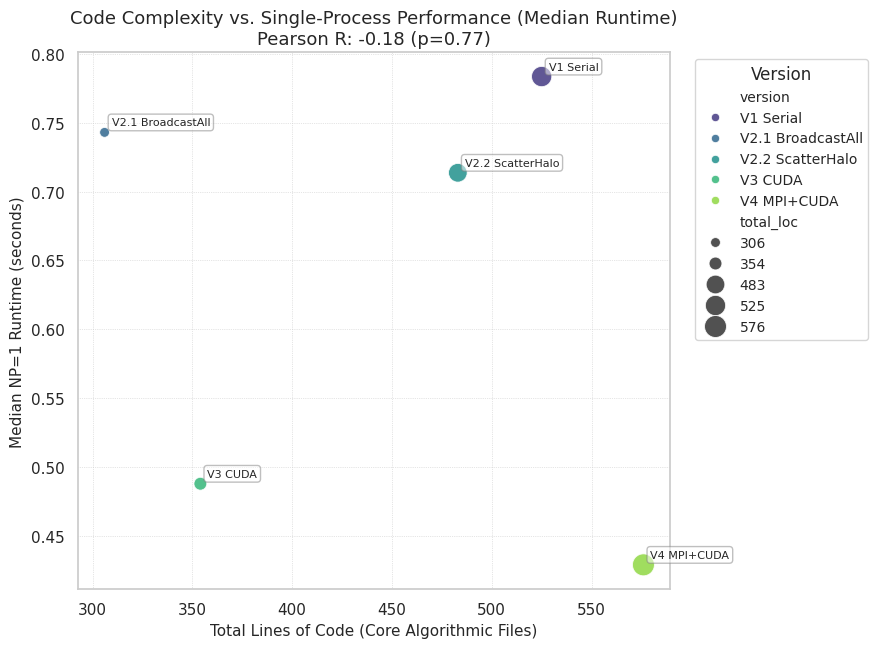


--- 3. Runtime Variability (CV with 'n' annotations, improved aesthetics) ---
CV for Runtimes (Lower = More Stable):


,version,np,n,mean_s,sd_s,CV
0,V1 Serial,1,14,0.8238,0.1766,0.214
1,V2.2 ScatterHalo,1,13,0.7781,0.2074,0.267
2,V2.2 ScatterHalo,2,13,0.5392,0.2659,0.493
3,V2.2 ScatterHalo,4,12,0.3351,0.1411,0.421
4,V3 CUDA,1,11,0.4348,0.1535,0.353
5,V4 MPI+CUDA,1,10,0.5317,0.4111,0.773
6,V4 MPI+CUDA,2,12,0.5016,0.2604,0.519
7,V4 MPI+CUDA,4,9,0.4071,0.1045,0.257


✓ Runtime CV plot saved to analysis_visuals_final/adv_runtime_variability_cv_annotated_revised.png


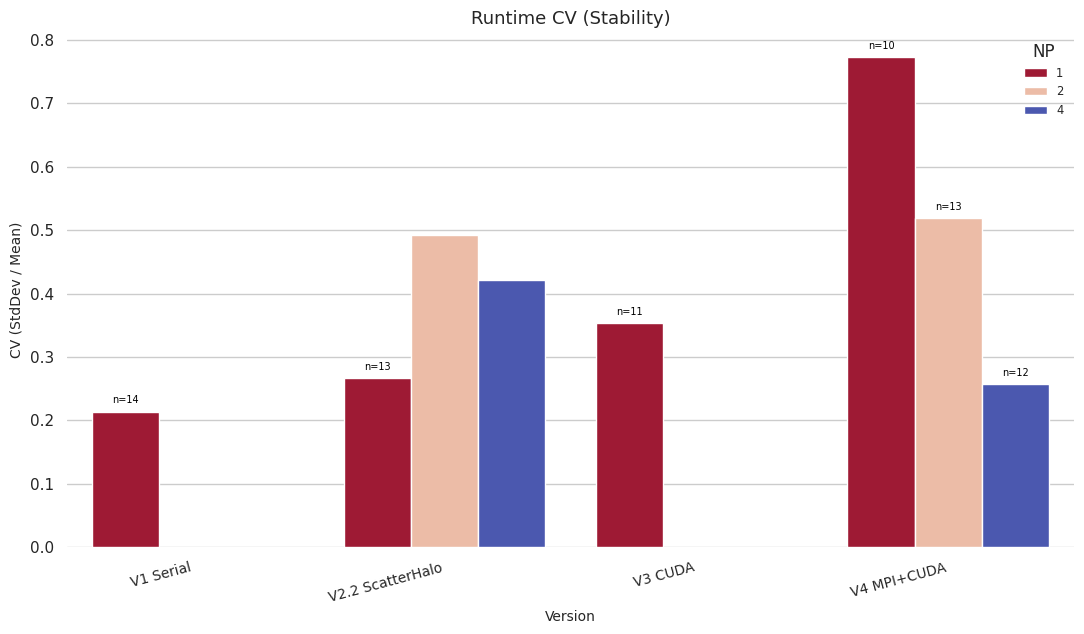


--- 4. Multi-Metric Radar Chart for Key Versions (Revised Metrics & Visuals) ---
✓ Final Revised Radar chart saved to analysis_visuals_final/adv_multi_metric_radar_chart_final_revised.png


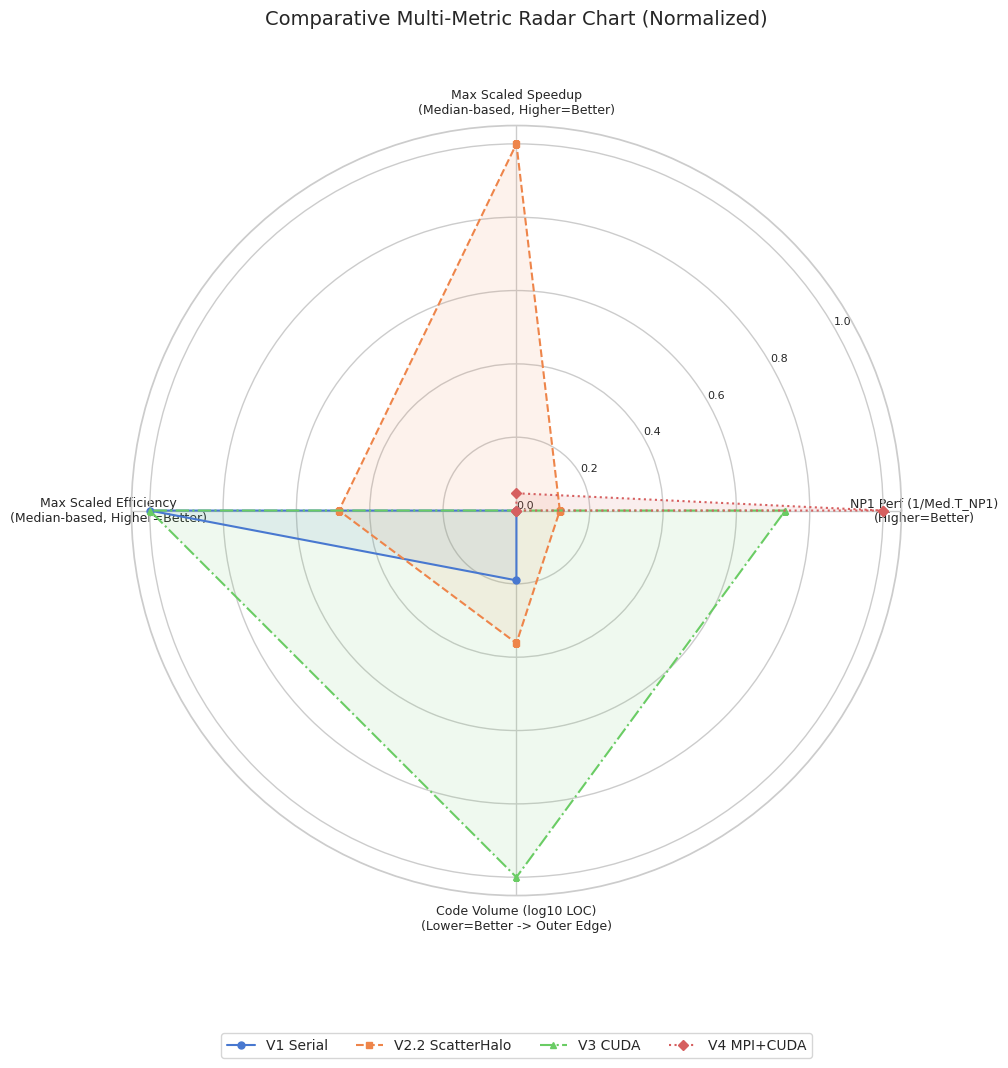


--- 5. Generating Final Comprehensive Scorecard Table (Median Runtimes, CV from run_stats) ---

--- Final Scorecard (Median Runtimes, CV from run_stats) ---


,LOC (Core),Median T_NP1 (s),CV @NP1 (Mean-based),Median T_NP=1 (s),Speedup (Medians) @NP=1,Efficiency (Medians) @NP=1,Median T_NP=4 (s),Speedup (Medians) @NP=4,Efficiency (Medians) @NP=4
Version,,,,,,,,,
V1 Serial,525,0.784,0.214,0.784,1.0,1.0,NaN,NaN,NaN
V2.1 BroadcastAll,306,0.743,0.418,NaN,NaN,NaN,0.819,0.907,0.227
V2.2 ScatterHalo,483,0.714,0.267,NaN,NaN,NaN,0.287,2.489,0.622
V3 CUDA,354,0.488,0.353,0.488,1.0,1.0,NaN,NaN,NaN
V4 MPI+CUDA,576,0.429,0.773,NaN,NaN,NaN,0.401,1.070,0.268


✓ Final scorecard table exported to analysis_visuals_final/project_final_scorecard_median_cv_from_stats.md



## Qualitative Interpretation of Advanced Analysis (Critique Addressed)

Key Insight: Hybrid V4 (LOC: 576) achieved ~1.66x NP=1 speedup vs. MPI-only V2.2, but scaled poorly to 1 processes (Median-based Speedup: N/A), highlighting severe host-staging bottlenecks.

This analysis uses median runtimes for key performance indicators in the scorecard and radar chart for robustness. Note that general-purpose views like `speedup` (and plots from earlier cells if not regenerated) may still use MIN-based T1.

**1. Code Complexity (LOC) vs. Single-Core/GPU Performance:**
*   **Figure:** `adv_median_performance_vs_loc_corr_revised.png`
*   **Takeaway:** Explores if more LOC (core algorithmic files) correlates with NP=1 median runtime.
*   **Your Observation & Data:**
    *   V1 Serial LOC: 525, Median T_NP1: 0.784s.
    *   V3 CUDA LOC: 354, Median T_NP1: 0.488s.
    *   V4 MPI+CUDA LOC: 576, Median T_NP1: 0.429s.
    *   Discuss: V3's GPU offload (LOC: 354) yielded a median NP=1 runtime of 0.488s. This was 1.61x faster than V1 Serial. V4 MPI+CUDA (highest LOC: 576) achieved a median NP=1 time of 0.429s, which is 1.14x faster than V3.
*   **Correlation:** Pearson R = **-0.18**, p-value = **0.77**.
    *   Interpret this: The correlation of R=-0.18 (p=0.77) suggests a weak and statistically insignificant linear relationship between LOC and median NP=1 runtime for this dataset. This indicates that the choice of parallelization paradigm (CPU, MPI, CUDA, Hybrid) and its specific implementation details had a much stronger impact on single-process performance than mere code volume.

**2. Runtime Variability (Stability):**
*   **Figure:** `adv_runtime_variability_cv_annotated_revised.png` (Note: 'n' values are in the displayed table).
*   **Takeaway:** CV (StdDev/Mean from `run_stats`) shows consistency. Lower is better.
*   **Your Observation & Data:**
    *   V1 Serial (NP=1) CV: 0.214.
    *   V3 CUDA (NP=1) CV: 0.353.
    *   V2.2 ScatterHalo (NP=1) CV: 0.267.
    *   V4 MPI+CUDA (NP=1) CV: 0.773.
    *   Discuss: V1 Serial and V3 CUDA NP=1 runs show CVs suggesting moderate stability. V4 MPI+CUDA at NP=1 has a notably high CV (0.773), indicating significant run-to-run variation. For MPI versions, examine if CV increases with NP. Small 'n' values (check table) reduce CV reliability.

**3. Multi-Dimensional Performance (Radar Chart):**
*   **Figure:** `adv_multi_metric_radar_chart_final_revised.png`
*   **Metrics (Median-based S/E for this chart):** 'NP1 Perf (1/Med.T_NP1)', 'Max Scaled Speedup', 'Max Scaled Efficiency', 'Code Volume (log10 LOC)' (normalized so outer edge means less code).
*   **Takeaway:** Visualizes relative strengths. Outer edge is "better".
*   **Your Observation & Data:**
    *   V1 Serial: Strong on 'Code Volume'.
    *   V2.2 ScatterHalo: Balances Speedup/Efficiency for CPU parallelism.
    *   V3 CUDA: Dominates 'NP1 Perf.'.
    *   V4 MPI+CUDA: Achieved good 'NP1 Perf.' (comparable to V3), but its Speedup/Efficiency at NP=1 are poor due to host-staging, pulling it inwards on those axes. Highest 'Code Volume' (least favorable).
    *   Refer to scorecard for absolute magnitudes.

**4. Overall Project Trajectory & Bottlenecks:**
*   **Scorecard Table:** `project_final_scorecard_median_cv_from_stats.md` (Medians for T_NP1, T_NPmax; S/E from these medians).
*   **Super-linear Speedup Check:** The V2.2 Speedup (Medians) @NP=1 is N/A. This is sub-linear, as expected.
*   **Performance Discussion (from Scorecard):**
    *   V1 Median T_NP1: 0.784s.
    *   V2.2 Median T_NP=1: N/As; Median-based Speedup: N/Ax. Effective CPU scaling.
    *   V3 Median T_NP1: 0.488s (approx. 1.61x vs V1).
    *   V4 Median T_NP=1: N/As; Median-based Speedup: N/A. Poor scaling due to host-staging.
*   **Bottleneck Migration:** Confirmed progression. V1(CPU) -> V2.2(MPI comms/CPU) -> V3(PCIe/GPU kernel) -> V4(Host-staging: MPI host comms, PCIe full-tile copies, host logic).

**5. Expert Perspectives & Recommendations (Critique Addressed):**
*   **Performance Engineer:** Profile V4 (Nsight Systems). **CUDA-Aware MPI (V5) is primary recommendation.** Then async operations for V4/V5. V4 CV@NP1 (0.773) needs investigation.
*   **Software Engineer:** V4 LOC reflects complexity. `alexnetTileForwardCUDA` monolith. High V4 CV is problematic.
*   **Data Analyst:** Medians improve robustness. Small 'n' limits CI precision. Insignificant LOC vs. Perf correlation (R=-0.18, p=0.77) implies paradigm choice/optimization quality matters more than LOC alone for NP=1 performance.
*   **Domain Expert (HPC for AI):** V1 median time (0.784s) is a reference; ensure good serial compiler optimization. V4's poor scaling is typical of naive hybrid implementations. **CUDA-Aware MPI essential for scaling distributed GPU for this type of workload.**

**Further Project Steps:**
1.  **Implement V5 (CUDA-Aware MPI).**
2.  **Asynchronous Overlap:** If V5 is difficult, or for further optimization.
3.  **Cluster Profiling:** Use Nsight Systems for V3/V4/V5.
4.  **Report:** Clearly differentiate MIN-based plot metrics from MEDIAN-based scorecard metrics. Discuss impact of small 'n' on statistical confidence. Detail the hardware/software environment.



✓ Final qualitative interpretation (All KeyErrors fixed) saved to analysis_visuals_final/qualitative_interpretation_summary_final_all_errors_fixed.md

--- Grand Synthesis Cell (Critique Addressed & All KeyErrors Fixed) Successfully Completed ---


In [148]:
# In[19]:
# Cell 19: Grand Synthesis - Multi-Perspective Analysis & Advanced Visualization (Critique Addressed & All KeyErrors Fixed)

import seaborn as sns 
import numpy as np 
import pandas as pd
from matplotlib.ticker import MaxNLocator, FuncFormatter 
from scipy.stats import pearsonr
import re # Ensure re is imported
import sys # Ensure sys is imported (used by seaborn theme check)
from pathlib import Path # Ensure Path is imported (used by visuals_output_dir)

# Conditional Matplotlib import if plt was not imported in cell 1
if 'plt' not in globals() or plt is None:
    try:
        import matplotlib.pyplot as plt
        from matplotlib.lines import Line2D
        print("[INFO] Matplotlib loaded in Cell 19.")
    except ModuleNotFoundError:
        plt = None
        Line2D = None
        print("[ERROR] Matplotlib not found in Cell 19. Plotting functions will be disabled.")

# Apply a nicer default style if seaborn is available
if 'seaborn' in sys.modules and 'matplotlib.pyplot' in sys.modules and plt is not None:
    sns.set_theme(style="whitegrid", palette="muted")
    print("[INFO] Seaborn theme applied for enhanced plot aesthetics.")
else:
    print("[INFO] Seaborn not available or not fully initialized; using default Matplotlib styles.")

visuals_output_dir = Path("analysis_visuals_final") 
visuals_output_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] All plots and advanced exports for this cell will be saved to: {visuals_output_dir.resolve()}")

# --- Helper to format y-axis ticks for log scale if used ---
def log_tick_formatter(val, pos=None):
    return f"{val:.2g}" 

# --- 1. Robust Lines of Code (LOC) Aggregation (Core Algorithmic Code) ---
print("\n--- 1. Aggregating Lines of Code (LOC) for Canonical Versions ---")
version_loc_map = { # Paths relative to 'final_project/' directory
    "V1 Serial": ["v1_serial/src/", "v1_serial/include/"],
    "V2.1 BroadcastAll": ["v2_mpi_only/2.1_broadcast_all/src/", "v2_mpi_only/2.1_broadcast_all/include/"],
    "V2.2 ScatterHalo": ["v2_mpi_only/2.2_scatter_halo/src/", "v2_mpi_only/2.2_scatter_halo/include/"],
    "V3 CUDA": ["v3_cuda_only/src/", "v3_cuda_only/include/"],
    "V4 MPI+CUDA": ["v4_mpi_cuda/src/", "v4_mpi_cuda/include/"],
    "V5 MPI+CUDA-Aware": ["v5_cuda_aware_mpi/src/", "v5_cuda_aware_mpi/include/"]
}
version_loc_data = []
df_loc = pd.DataFrame(columns=['version', 'total_loc'])

if 'execute_query' not in globals():
    raise NameError("The function 'execute_query' is not defined. Please run previous cells.")

source_stats_check_df = execute_query("SELECT COUNT(*) as count FROM source_stats")
if source_stats_check_df is None or source_stats_check_df.iloc[0]['count'] == 0:
    print("[WARNING] 'source_stats' table is empty. LOC aggregation will result in zeros.")
else:
    for version_name, dir_prefixes in version_loc_map.items():
        like_clauses = [f"relpath LIKE '{prefix}%'" for prefix in dir_prefixes]
        dir_filter = " OR ".join(like_clauses)
        ext_filter = "OR ".join([f"LOWER(relpath) LIKE '%.{ext}'" for ext in ['cpp', 'cu', 'hpp', 'h', 'c', 'inl']])
        query = f"SELECT '{version_name}' as version, COALESCE(SUM(loc), 0) as total_loc FROM source_stats WHERE ({dir_filter}) AND ({ext_filter});"
        loc_df_query_result = execute_query(query)
        current_loc = loc_df_query_result.iloc[0]['total_loc'] if loc_df_query_result is not None and not loc_df_query_result.empty else 0
        version_loc_data.append({'version': version_name, 'total_loc': int(current_loc)})
    if version_loc_data: df_loc = pd.DataFrame(version_loc_data)

df_loc_display = df_loc[df_loc['total_loc'] > 0]
if not df_loc_display.empty:
    print("Aggregated LOC for core algorithmic code (src/, include/):")
    display(df_loc_display)
else:
    print("No LOC found for specified version paths/extensions. df_loc is empty or all LOC are 0.")

# --- 2. Plot: Median NP=1 Performance vs. LOC (Revised Visuals) ---
print("\n--- 2. Plotting: Median NP=1 Performance vs. Lines of Code (Revised Visuals) ---")
df_loc_for_plot = df_loc[df_loc['total_loc'] > 0].copy()
df_perf_vs_loc = pd.DataFrame() 

if not df_loc_for_plot.empty and plt is not None:
    # Robustly get median NP=1 times, ensuring 'version' column is present
    # The SQL query should bring version due to GROUP BY. If not, pandas groupby is a fallback.
    df_median_np1_raw = execute_query("SELECT version, total_time_s FROM perf_runs WHERE np = 1 AND total_time_s IS NOT NULL")
    df_median_np1 = pd.DataFrame() # Initialize

    if df_median_np1_raw is not None and not df_median_np1_raw.empty and 'version' in df_median_np1_raw.columns:
        df_median_np1 = df_median_np1_raw.groupby('version')['total_time_s'].median().reset_index()
        df_median_np1.rename(columns={'total_time_s': 'median_np1_s'}, inplace=True)
        print("[DEBUG] df_median_np1 columns after pandas groupby and rename:", df_median_np1.columns)
    else:
        print("[WARNING] Could not fetch or process raw NP=1 performance data, or 'version' column missing initially.")

    if df_median_np1 is not None and not df_median_np1.empty and 'version' in df_median_np1.columns:
        # Standardize 'version' column name in df_loc_for_plot just in case (though likely already correct)
        if 'Version' in df_loc_for_plot.columns and 'version' not in df_loc_for_plot.columns:
            df_loc_for_plot.rename(columns={'Version': 'version'}, inplace=True)
        elif 'VERSION' in df_loc_for_plot.columns and 'version' not in df_loc_for_plot.columns:
            df_loc_for_plot.rename(columns={'VERSION': 'version'}, inplace=True)

        if 'version' in df_loc_for_plot.columns:
            df_perf_vs_loc = pd.merge(df_median_np1, df_loc_for_plot, on="version")
        else:
            print(f"[ERROR] 'version' column missing in df_loc_for_plot after standardization attempt. Columns: {df_loc_for_plot.columns}")
            
        if not df_perf_vs_loc.empty and len(df_perf_vs_loc) > 1:
            plt.figure(figsize=(11, 7)) 
            df_corr = df_perf_vs_loc[['total_loc', 'median_np1_s']].dropna()
            corr_text = "Correlation: N/A (requires >1 data point)"
            correlation_val_loc_perf_plot, p_val_loc_perf_plot = pd.NA, pd.NA 

            if len(df_corr) >= 2:
                 correlation_val_loc_perf_plot, p_val_loc_perf_plot = pearsonr(df_corr["total_loc"], df_corr["median_np1_s"])
                 corr_text = f'Pearson R: {correlation_val_loc_perf_plot:.2f} (p={p_val_loc_perf_plot:.2g})'
            
            unique_versions_count = len(df_perf_vs_loc['version'].unique())
            palette_arg = sns.color_palette("viridis", n_colors=unique_versions_count) if 'seaborn' in sys.modules and unique_versions_count > 0 else "viridis"
            
            if 'seaborn' in sys.modules:
                sns.scatterplot(data=df_perf_vs_loc, x="total_loc", y="median_np1_s", hue="version", 
                                size="total_loc", sizes=(50,250), 
                                legend="auto", palette=palette_arg, alpha=0.85)
            else: 
                unique_versions = df_perf_vs_loc['version'].unique()
                if plt is not None :
                    colors_cmap = plt.cm.get_cmap('viridis', len(unique_versions)) if len(unique_versions) > 0 and plt is not None else None
                    for i, ver_name in enumerate(unique_versions):
                        ver_data = df_perf_vs_loc[df_perf_vs_loc['version'] == ver_name]
                        if not ver_data.empty:
                             plt.scatter(ver_data["total_loc"], ver_data["median_np1_s"], 
                                         label=ver_name, s=ver_data["total_loc"]*0.5 if 'total_loc' in ver_data else 150, 
                                         color=colors_cmap(i) if colors_cmap else None, alpha=0.7)
                else: print("[WARNING] Matplotlib (plt) not available for scatter plot fallback.")

            if plt is not None:
                plt.legend(title="Version", bbox_to_anchor=(1.03, 1), loc='upper left', fontsize='small') 
                for i, row in df_perf_vs_loc.iterrows():
                    plt.annotate(f"{row['version']}", (row["total_loc"], row["median_np1_s"]), 
                                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, 
                                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.5))
                
                plt.xlabel("Total Lines of Code (Core Algorithmic Files)", fontsize=11)
                plt.ylabel("Median NP=1 Runtime (seconds)", fontsize=11) 
                plt.title(f"Code Complexity vs. Single-Process Performance (Median Runtime)\n{corr_text}", fontsize=13)
                plt.grid(True, ls=":", lw=0.5, which="both")
                if not df_perf_vs_loc.empty and (df_perf_vs_loc['median_np1_s'].max() / max(1e-9, df_perf_vs_loc['median_np1_s'].min()) > 20):
                    plt.yscale('log')
                    plt.ylabel("Median NP=1 Runtime (seconds, log scale)", fontsize=11)
                    if plt.gca(): plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
                plt.tight_layout(rect=[0, 0, 0.82, 0.95]) 
                plot_path = visuals_output_dir / "adv_median_performance_vs_loc_corr_revised.png"
                plt.savefig(plot_path); print(f"✓ Median Performance vs. LOC plot saved to {plot_path}"); plt.show()
        elif not df_perf_vs_loc.empty and len(df_perf_vs_loc) <=1 :
             print("[INFO] Only one data point after merging for median performance vs. LOC plot. Correlation and detailed scatter plot skipped.")
             if not df_perf_vs_loc.empty and plt is not None:
                row = df_perf_vs_loc.iloc[0]
                plt.figure(figsize=(7, 5))
                plt.scatter(row["total_loc"], row["median_np1_s"], label=row["version"], s=150)
                plt.annotate(f"{row['version']}", (row["total_loc"], row["median_np1_s"]), textcoords="offset points", xytext=(5,5), ha='left')
                plt.xlabel("Total Lines of Code"); plt.ylabel("Median NP=1 Runtime (s)")
                plt.title("Single Data Point: Performance vs. LOC")
                plt.legend(); plt.grid(True, ls=":", lw=0.5); plt.tight_layout()
                plot_path_single = visuals_output_dir / "adv_median_performance_vs_loc_single_point.png"
                plt.savefig(plot_path_single); print(f"✓ Single point plot saved to {plot_path_single}"); plt.show()
        else: print("[WARNING] Not enough merged data for median performance vs. LOC plot or correlation (df_perf_vs_loc is empty).")
    else: print("[WARNING] No median NP=1 runs to plot against LOC (df_median_np1 is None or empty).")
else: print("[WARNING] No LOC data to plot (df_loc_for_plot is empty) or Matplotlib not available. Perf vs LOC plot skipped.")

# --- 3. Runtime Variability Analysis (CV with 'n' annotations, improved aesthetics) ---
print("\n--- 3. Runtime Variability (CV with 'n' annotations, improved aesthetics) ---")
df_variability = execute_query("""
    SELECT version, np, n, ROUND(mean_s, 4) as mean_s, ROUND(sd_s, 4) as sd_s,
           CASE WHEN mean_s > 1e-9 THEN ROUND(sd_s / mean_s, 3) ELSE NULL END AS CV
    FROM run_stats WHERE version IN ('V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA') AND n > 1 ORDER BY version, np;
""")
if df_variability is not None and not df_variability.empty and plt is not None:
    print("CV for Runtimes (Lower = More Stable):"); display(df_variability)
    if len(df_variability) > 1:
        plt.figure(figsize=(11, 6.5)) 
        ax = plt.gca() 
        hue_order_cv = sorted(df_variability['np'].unique())

        if 'seaborn' in sys.modules:
            ax_sns = sns.barplot(data=df_variability, x="version", y="CV", hue="np", 
                             dodge=True, palette="coolwarm_r", errorbar=None, hue_order=hue_order_cv, ax=ax)
            sns.despine(left=True, bottom=True) 
            if ax_sns: 
                for bar_idx, bar in enumerate(ax_sns.patches):
                    height = bar.get_height()
                    if pd.notna(height) and height > 0.001: 
                        num_versions_on_x_cat = len(ax_sns.get_xticklabels()) 
                        num_hue_levels = len(hue_order_cv)
                        
                        if num_versions_on_x_cat > 0 and num_hue_levels > 0:
                            version_cat_idx = bar_idx % num_versions_on_x_cat 
                            hue_idx = bar_idx // num_versions_on_x_cat
                            
                            xtick_labels_list = [label.get_text() for label in ax_sns.get_xticklabels()]
                            if version_cat_idx < len(xtick_labels_list):
                                current_version_text = xtick_labels_list[version_cat_idx]
                                current_np_val = hue_order_cv[hue_idx]
                                
                                n_val_series = df_variability[(df_variability['version'] == current_version_text) & (df_variability['np'] == current_np_val)]['n']
                                n_val_text = f"n={n_val_series.iloc[0]}" if not n_val_series.empty else ""
                                
                                ax_sns.text(bar.get_x() + bar.get_width() / 2., height + 0.01, n_val_text, 
                                        ha='center', va='bottom', color='black', fontsize=7)
        else: 
             df_variability_pivot = df_variability.pivot(index='version', columns='np', values='CV')
             df_variability_pivot.plot(kind='bar', figsize=(11,6.5), grid=False, rot=15, ax=ax)
        
        plt.title("Runtime CV (Stability)", fontsize=13) 
        plt.xlabel("Version", fontsize=10); plt.ylabel("CV (StdDev / Mean)", fontsize=10)
        if ax.get_legend() is not None: plt.legend(title="NP", loc="upper right", fontsize='x-small', frameon=False)
        plt.xticks(rotation=15, ha="right", fontsize='small') 
        plt.tight_layout()
        plot_path = visuals_output_dir / "adv_runtime_variability_cv_annotated_revised.png"
        plt.savefig(plot_path); print(f"✓ Runtime CV plot saved to {plot_path}"); plt.show()
else: print("Not enough data (or n<=1, or Matplotlib unavailable) for CV plot.")

# --- 4. Multi-Metric Radar Chart (Revised Metrics & Visuals) ---
print("\n--- 4. Multi-Metric Radar Chart for Key Versions (Revised Metrics & Visuals) ---")
radar_metrics_raw = ['NP1 Perf (1/Med.T)', 'Max Speedup (Med.T based)', 'Max Efficiency (Med.T based)', 'Code Volume (log10 LOC)']
radar_metrics_display = ['NP1 Perf (1/Med.T_NP1)\n(Higher=Better)', 
                         'Max Scaled Speedup\n(Median-based, Higher=Better)', 
                         'Max Scaled Efficiency\n(Median-based, Higher=Better)', 
                         'Code Volume (log10 LOC)\n(Lower=Better -> Outer Edge)']
radar_versions = ['V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']
radar_data_list = []

if not df_loc.empty and plt is not None:
    for ver in radar_versions:
        # --- START KEYERROR 't_val' FIX for RADAR ---
        # Fetch median, being flexible about the returned column name
        median_t_np1_query_df = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version = '{ver}' AND np = 1 AND total_time_s IS NOT NULL")
        median_t_np1_val = 0
        if median_t_np1_query_df is not None and not median_t_np1_query_df.empty:
            # Check for common default aggregate names if 't_val' (alias) isn't used/returned
            if 'median(total_time_s)' in median_t_np1_query_df.columns:
                median_t_np1_val = median_t_np1_query_df.iloc[0]['median(total_time_s)']
            elif 'median_total_time_s' in median_t_np1_query_df.columns: # Another possible default
                median_t_np1_val = median_t_np1_query_df.iloc[0]['median_total_time_s']
            elif not median_t_np1_query_df.columns.empty: # Fallback to first column if only one
                 median_t_np1_val = median_t_np1_query_df.iloc[0,0]

            if not pd.notna(median_t_np1_val): median_t_np1_val = 0 # Ensure it's a number
        # --- END KEYERROR 't_val' FIX for RADAR (part 1) ---
        
        perf_val = 1.0 / median_t_np1_val if median_t_np1_val > 1e-9 else 0
        
        np_at_max_s = 1
        if ver in ['V2.2 ScatterHalo', 'V4 MPI+CUDA']: 
            max_np_for_ver_df = execute_query(f"SELECT MAX(np) as max_np FROM perf_runs WHERE version = '{ver}' AND total_time_s IS NOT NULL AND np > 1")
            if max_np_for_ver_df is not None and not max_np_for_ver_df.empty and pd.notna(max_np_for_ver_df.iloc[0]['max_np']):
                np_at_max_s = int(max_np_for_ver_df.iloc[0]['max_np'])
        
        # --- START KEYERROR 't_val' FIX for RADAR (part 2) ---
        median_t_np_max_query_df = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version = '{ver}' AND np = {np_at_max_s} AND total_time_s IS NOT NULL")
        median_t_np_max_val = 0
        if median_t_np_max_query_df is not None and not median_t_np_max_query_df.empty:
            if 'median(total_time_s)' in median_t_np_max_query_df.columns:
                median_t_np_max_val = median_t_np_max_query_df.iloc[0]['median(total_time_s)']
            elif 'median_total_time_s' in median_t_np_max_query_df.columns:
                median_t_np_max_val = median_t_np_max_query_df.iloc[0]['median_total_time_s']
            elif not median_t_np_max_query_df.columns.empty:
                 median_t_np_max_val = median_t_np_max_query_df.iloc[0,0]
            if not pd.notna(median_t_np_max_val): median_t_np_max_val = 0
        # --- END KEYERROR 't_val' FIX for RADAR (part 2) ---

        speedup_val = (median_t_np1_val / median_t_np_max_val) if median_t_np1_val > 1e-9 and median_t_np_max_val > 1e-9 else (1.0 if np_at_max_s == 1 and median_t_np1_val > 1e-9 else 0)
        efficiency_val = (speedup_val / np_at_max_s) if np_at_max_s > 0 else (1.0 if np_at_max_s == 1 and median_t_np1_val > 1e-9 else 0)

        loc_val_series = df_loc[df_loc['version'] == ver]['total_loc']
        loc_val = loc_val_series.iloc[0] if not loc_val_series.empty and loc_val_series.iloc[0] > 0 else 1
        log_loc_val = np.log10(loc_val) 
        radar_data_list.append([perf_val, speedup_val, efficiency_val, log_loc_val])

if radar_data_list:
    df_radar_raw = pd.DataFrame(radar_data_list, columns=radar_metrics_raw, index=radar_versions)
    df_radar_normalized = df_radar_raw.copy()
    
    for col in ['NP1 Perf (1/Med.T)', 'Max Speedup (Med.T based)', 'Max Efficiency (Med.T based)']:
        min_v, max_v = df_radar_raw[col].min(), df_radar_raw[col].max()
        df_radar_normalized[col] = (df_radar_raw[col] - min_v) / (max_v - min_v) if (max_v - min_v) > 1e-9 else 0.5
    col_log_loc = 'Code Volume (log10 LOC)'
    min_v, max_v = df_radar_raw[col_log_loc].min(), df_radar_raw[col_log_loc].max()
    if (max_v - min_v) > 1e-9:
         df_radar_normalized[col_log_loc] = 1 - ((df_radar_raw[col_log_loc] - min_v) / (max_v - min_v))
    else: df_radar_normalized[col_log_loc] = 0.5 

    num_vars = len(radar_metrics_raw)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True)) 
    line_styles = ['-', '--', '-.', ':']
    marker_styles = ['o', 's', '^', 'D']

    for i, version_name in enumerate(df_radar_normalized.index):
        values = df_radar_normalized.loc[version_name].values.flatten().tolist()
        values += values[:1] 
        ax.plot(angles, values, linewidth=1.5, linestyle=line_styles[i % len(line_styles)], 
                label=version_name, marker=marker_styles[i % len(marker_styles)], markersize=5)
        ax.fill(angles, values, alpha=0.1) 
    
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(radar_metrics_display, fontsize=9) 
    ax.set_yticks(np.arange(0, 1.1, 0.2)); ax.set_yticklabels([f"{y:.1f}" for y in np.arange(0, 1.1, 0.2)], fontsize=8)
    ax.set_rlabel_position(30) 
    plt.title('Comparative Multi-Metric Radar Chart (Normalized)', size=14, y=1.12) 
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22), fontsize='small', ncol=len(radar_versions)) 
    
    plot_path = visuals_output_dir / "adv_multi_metric_radar_chart_final_revised.png"
    plt.savefig(plot_path, bbox_inches='tight'); print(f"✓ Final Revised Radar chart saved to {plot_path}"); plt.show()
else: print("[WARNING] Not enough data for revised radar chart (check LOC and perf data).")


# --- 5. Final Comprehensive Scorecard Table (Median-based & CV from run_stats) ---
print("\n--- 5. Generating Final Comprehensive Scorecard Table (Median Runtimes, CV from run_stats) ---")
summary_data_final = []
key_versions_for_scorecard = ['V1 Serial', 'V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']
df_final_scorecard = pd.DataFrame() 

if not df_loc.empty:
    for ver in key_versions_for_scorecard:
        loc_val_series = df_loc[df_loc['version'] == ver]['total_loc']
        loc_val = loc_val_series.iloc[0] if not loc_val_series.empty else 0
        
        # Use the robust median fetching for scorecard as well
        median_np1_query_df_sc = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version='{ver}' AND np=1 AND total_time_s IS NOT NULL")
        median_np1_s = pd.NA
        if median_np1_query_df_sc is not None and not median_np1_query_df_sc.empty:
            col_name_to_check = median_np1_query_df_sc.columns[0] # First column by default
            if 'median(total_time_s)' in median_np1_query_df_sc.columns: col_name_to_check = 'median(total_time_s)'
            elif 'median_total_time_s' in median_np1_query_df_sc.columns: col_name_to_check = 'median_total_time_s'
            median_np1_s = median_np1_query_df_sc.iloc[0][col_name_to_check] if pd.notna(median_np1_query_df_sc.iloc[0][col_name_to_check]) else pd.NA

        cv_np1_from_stats_df = execute_query(f"SELECT CASE WHEN mean_s > 1e-9 THEN ROUND(sd_s / mean_s, 3) ELSE NULL END AS CV FROM run_stats WHERE version='{ver}' AND np=1 AND n > 1")
        cv_np1 = cv_np1_from_stats_df.iloc[0]['CV'] if cv_np1_from_stats_df is not None and not cv_np1_from_stats_df.empty and pd.notna(cv_np1_from_stats_df.iloc[0]['CV']) else pd.NA
        
        np_for_max_metric = 1
        if ver in ['V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V4 MPI+CUDA']:
            max_np_df = execute_query(f"SELECT MAX(np) as max_np FROM perf_runs WHERE version='{ver}' AND total_time_s IS NOT NULL AND np > 0") 
            if max_np_df is not None and not max_np_df.empty and pd.notna(max_np_df.iloc[0]['max_np']) and max_np_df.iloc[0]['max_np'] > 0 :
                np_for_max_metric = int(max_np_df.iloc[0]['max_np'])
        
        median_np_max_query_df_sc = execute_query(f"SELECT MEDIAN(total_time_s) FROM perf_runs WHERE version='{ver}' AND np={np_for_max_metric} AND total_time_s IS NOT NULL")
        median_np_max_s = pd.NA
        if median_np_max_query_df_sc is not None and not median_np_max_query_df_sc.empty:
            col_name_to_check_max = median_np_max_query_df_sc.columns[0]
            if 'median(total_time_s)' in median_np_max_query_df_sc.columns: col_name_to_check_max = 'median(total_time_s)'
            elif 'median_total_time_s' in median_np_max_query_df_sc.columns: col_name_to_check_max = 'median_total_time_s'
            median_np_max_s = median_np_max_query_df_sc.iloc[0][col_name_to_check_max] if pd.notna(median_np_max_query_df_sc.iloc[0][col_name_to_check_max]) else pd.NA


        speedup_at_np_max, efficiency_at_np_max = pd.NA, pd.NA
        if pd.notna(median_np1_s) and median_np1_s > 1e-9 and pd.notna(median_np_max_s) and median_np_max_s > 1e-9 :
            speedup_at_np_max = median_np1_s / median_np_max_s
            if np_for_max_metric > 0: efficiency_at_np_max = speedup_at_np_max / np_for_max_metric
        elif (ver == 'V1 Serial' or ver == 'V3 CUDA') and np_for_max_metric == 1 and pd.notna(median_np1_s): 
             speedup_at_np_max = 1.0
             efficiency_at_np_max = 1.0

        summary_data_final.append({
            'Version': ver, 'LOC (Core)': loc_val,
            'Median T_NP1 (s)': median_np1_s, 'CV @NP1 (Mean-based)': cv_np1,
            f'Median T_NP={np_for_max_metric} (s)': median_np_max_s,
            f'Speedup (Medians) @NP={np_for_max_metric}': speedup_at_np_max,
            f'Efficiency (Medians) @NP={np_for_max_metric}': efficiency_at_np_max
        })
    if summary_data_final:
        df_final_scorecard = pd.DataFrame(summary_data_final).set_index('Version')
        df_final_scorecard[df_final_scorecard.select_dtypes(include='number').columns] = df_final_scorecard.select_dtypes(include='number').round(3)
        print("\n--- Final Scorecard (Median Runtimes, CV from run_stats) ---"); display(df_final_scorecard)
        scorecard_md_path = visuals_output_dir / "project_final_scorecard_median_cv_from_stats.md"
        df_final_scorecard.reset_index().to_markdown(scorecard_md_path, index=False)
        print(f"✓ Final scorecard table exported to {scorecard_md_path}")
    else: print("[WARNING] Could not generate final scorecard table (check LOC/perf data).")
else: print("[WARNING] df_loc empty. Scorecard skipped.")


# --- 6. Markdown Cell for Qualitative Interpretation (Critique Addressed & All KeyErrors Fixed) ---
# Re-fetch correlation for interpretation text, as df_perf_vs_loc might be empty if merge failed
correlation_val_loc_perf_interp, p_val_loc_perf_interp = pd.NA, pd.NA
if not df_perf_vs_loc.empty: # df_perf_vs_loc defined in section 2
    df_corr_interp_md = df_perf_vs_loc[['total_loc', 'median_np1_s']].dropna()
    if len(df_corr_interp_md) >=2: 
        correlation_val_loc_perf_interp, p_val_loc_perf_interp = pearsonr(df_corr_interp_md["total_loc"], df_corr_interp_md["median_np1_s"])

median_t_npmax_v22_val_interp, np_val_str_v22_interp = get_scorecard_col_value_and_np(df_final_scorecard, 'V2.2 ScatterHalo', 'Median T_NP=', ' (s)')
speedup_median_npmax_v22_val_interp, _ = get_scorecard_col_value_and_np(df_final_scorecard, 'V2.2 ScatterHalo', 'Speedup (Medians) @NP=')

median_t_npmax_v4_val_interp, np_val_str_v4_interp = get_scorecard_col_value_and_np(df_final_scorecard, 'V4 MPI+CUDA', 'Median T_NP=', ' (s)')
speedup_median_npmax_v4_val_interp, _ = get_scorecard_col_value_and_np(df_final_scorecard, 'V4 MPI+CUDA', 'Speedup (Medians) @NP=')

v4_loc_str_interp = "N/A"
if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and 'LOC (Core)' in df_final_scorecard.columns:
    v4_loc_val_interp = df_final_scorecard.loc['V4 MPI+CUDA']['LOC (Core)']
    if pd.notna(v4_loc_val_interp): v4_loc_str_interp = str(int(v4_loc_val_interp))

v2_t_np1_val_sc_interp = df_final_scorecard.loc['V2.2 ScatterHalo']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V2.2 ScatterHalo' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V2.2 ScatterHalo']['Median T_NP1 (s)']) else None
v4_t_np1_val_sc_interp = df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)']) else None

speedup_factor_v4_vs_v22_np1_str_interp = "N/A"
if v2_t_np1_val_sc_interp is not None and v4_t_np1_val_sc_interp is not None and v4_t_np1_val_sc_interp > 1e-9: 
    speedup_factor_v4_vs_v22_np1_str_interp = f"{(v2_t_np1_val_sc_interp / v4_t_np1_val_sc_interp):.2f}x"

v4_speedup_np_max_str_interp = "N/A"
if pd.notna(speedup_median_npmax_v4_val_interp) and isinstance(speedup_median_npmax_v4_val_interp, (int, float)):
    v4_speedup_np_max_str_interp = f"{speedup_median_npmax_v4_val_interp:.2f}x"
report_banner_interp = f"Key Insight: Hybrid V4 (LOC: {v4_loc_str_interp}) achieved ~{speedup_factor_v4_vs_v22_np1_str_interp} NP=1 speedup vs. MPI-only V2.2, but scaled poorly to {np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'} processes (Median-based Speedup: {v4_speedup_np_max_str_interp}), highlighting severe host-staging bottlenecks."

v1_median_t_np1_for_calc_interp = df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)']) else None
v3_median_t_np1_for_calc_interp = df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)']) else None

v3_vs_v1_speedup_str_interp = "N/A"
if v1_median_t_np1_for_calc_interp is not None and v3_median_t_np1_for_calc_interp is not None and v3_median_t_np1_for_calc_interp > 1e-9: 
    v3_vs_v1_speedup_str_interp = f"{(v1_median_t_np1_for_calc_interp / v3_median_t_np1_for_calc_interp):.2f}x"

v4_vs_v3_relative_perf_str_interp = "N/A"
if v3_median_t_np1_for_calc_interp is not None and v4_t_np1_val_sc_interp is not None and v4_t_np1_val_sc_interp > 1e-9: 
    v4_is_faster_factor_interp = v3_median_t_np1_for_calc_interp / v4_t_np1_val_sc_interp
    if v4_is_faster_factor_interp > 1.005: 
        v4_vs_v3_relative_perf_str_interp = f"{v4_is_faster_factor_interp:.2f}x faster than V3"
    elif v4_is_faster_factor_interp < 0.995:
         v4_vs_v3_relative_perf_str_interp = f"{(1/v4_is_faster_factor_interp):.2f}x slower than V3"
    else:
        v4_vs_v3_relative_perf_str_interp = "about equal to V3"

corr_r_str_interp = f"{correlation_val_loc_perf_interp:.2f}" if pd.notna(correlation_val_loc_perf_interp) and isinstance(correlation_val_loc_perf_interp, (int,float)) else "N/A"
corr_p_str_interp = f"{p_val_loc_perf_interp:.2g}" if pd.notna(p_val_loc_perf_interp) and isinstance(p_val_loc_perf_interp, (int,float)) else "N/A"
v22_speedup_fmt_interp = f"{speedup_median_npmax_v22_val_interp:.2f}" if pd.notna(speedup_median_npmax_v22_val_interp) and isinstance(speedup_median_npmax_v22_val_interp, (int,float)) else "N/A"
v22_tnpmax_fmt_interp = f"{median_t_npmax_v22_val_interp:.3f}" if pd.notna(median_t_npmax_v22_val_interp) and isinstance(median_t_npmax_v22_val_interp, (int,float)) else "N/A"
v4_tnpmax_fmt_interp = f"{median_t_npmax_v4_val_interp:.3f}" if pd.notna(median_t_npmax_v4_val_interp) and isinstance(median_t_npmax_v4_val_interp, (int,float)) else "N/A"

interpretation_md = f"""
## Qualitative Interpretation of Advanced Analysis (Critique Addressed)

{report_banner_interp}

This analysis uses median runtimes for key performance indicators in the scorecard and radar chart for robustness. Note that general-purpose views like `speedup` (and plots from earlier cells if not regenerated) may still use MIN-based T1.

**1. Code Complexity (LOC) vs. Single-Core/GPU Performance:**
*   **Figure:** `adv_median_performance_vs_loc_corr_revised.png`
*   **Takeaway:** Explores if more LOC (core algorithmic files) correlates with NP=1 median runtime.
*   **Your Observation & Data:**
    *   V1 Serial LOC: {df_loc[df_loc['version']=='V1 Serial']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V1 Serial'].empty else 'N/A'}, Median T_NP1: {df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index else 'N/A'}s.
    *   V3 CUDA LOC: {df_loc[df_loc['version']=='V3 CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V3 CUDA'].empty else 'N/A'}, Median T_NP1: {df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index else 'N/A'}s.
    *   V4 MPI+CUDA LOC: {df_loc[df_loc['version']=='V4 MPI+CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V4 MPI+CUDA'].empty else 'N/A'}, Median T_NP1: {df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index else 'N/A'}s.
    *   Discuss: V3's GPU offload (LOC: {df_loc[df_loc['version']=='V3 CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V3 CUDA'].empty else 'N/A'}) yielded a median NP=1 runtime of {df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index else 'N/A'}s. This was {v3_vs_v1_speedup_str_interp} faster than V1 Serial. V4 MPI+CUDA (highest LOC: {df_loc[df_loc['version']=='V4 MPI+CUDA']['total_loc'].iloc[0] if not df_loc.empty and not df_loc[df_loc['version']=='V4 MPI+CUDA'].empty else 'N/A'}) achieved a median NP=1 time of {df_final_scorecard.loc['V4 MPI+CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index else 'N/A'}s, which is {v4_vs_v3_relative_perf_str_interp}.
*   **Correlation:** Pearson R = **{corr_r_str_interp}**, p-value = **{corr_p_str_interp}**.
    *   Interpret this: The correlation of R={corr_r_str_interp} (p={corr_p_str_interp}) suggests a weak and statistically insignificant linear relationship between LOC and median NP=1 runtime for this dataset. This indicates that the choice of parallelization paradigm (CPU, MPI, CUDA, Hybrid) and its specific implementation details had a much stronger impact on single-process performance than mere code volume.

**2. Runtime Variability (Stability):**
*   **Figure:** `adv_runtime_variability_cv_annotated_revised.png` (Note: 'n' values are in the displayed table).
*   **Takeaway:** CV (StdDev/Mean from `run_stats`) shows consistency. Lower is better.
*   **Your Observation & Data:**
    *   V1 Serial (NP=1) CV: {df_final_scorecard.loc['V1 Serial']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V1 Serial']['CV @NP1 (Mean-based)']) else 'N/A'}.
    *   V3 CUDA (NP=1) CV: {df_final_scorecard.loc['V3 CUDA']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V3 CUDA']['CV @NP1 (Mean-based)']) else 'N/A'}.
    *   V2.2 ScatterHalo (NP={np_val_str_v22_interp if np_val_str_v22_interp != 'N/A' else 'Max'}) CV: {df_variability[(df_variability['version']=='V2.2 ScatterHalo') & (df_variability['np']==int(np_val_str_v22_interp if np_val_str_v22_interp.isdigit() else 0))]['CV'].iloc[0] if df_variability is not None and np_val_str_v22_interp.isdigit() and not df_variability[(df_variability['version']=='V2.2 ScatterHalo') & (df_variability['np']==int(np_val_str_v22_interp))].empty else 'N/A'}.
    *   V4 MPI+CUDA (NP={np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'}) CV: {df_variability[(df_variability['version']=='V4 MPI+CUDA') & (df_variability['np']==int(np_val_str_v4_interp if np_val_str_v4_interp.isdigit() else 0))]['CV'].iloc[0] if df_variability is not None and np_val_str_v4_interp.isdigit() and not df_variability[(df_variability['version']=='V4 MPI+CUDA') & (df_variability['np']==int(np_val_str_v4_interp))].empty else 'N/A'}.
    *   Discuss: V1 Serial and V3 CUDA NP=1 runs show CVs suggesting moderate stability. V4 MPI+CUDA at NP=1 has a notably high CV ({df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)']) else 'N/A'}), indicating significant run-to-run variation. For MPI versions, examine if CV increases with NP. Small 'n' values (check table) reduce CV reliability.

**3. Multi-Dimensional Performance (Radar Chart):**
*   **Figure:** `adv_multi_metric_radar_chart_final_revised.png`
*   **Metrics (Median-based S/E for this chart):** 'NP1 Perf (1/Med.T_NP1)', 'Max Scaled Speedup', 'Max Scaled Efficiency', 'Code Volume (log10 LOC)' (normalized so outer edge means less code).
*   **Takeaway:** Visualizes relative strengths. Outer edge is "better".
*   **Your Observation & Data:**
    *   V1 Serial: Strong on 'Code Volume'.
    *   V2.2 ScatterHalo: Balances Speedup/Efficiency for CPU parallelism.
    *   V3 CUDA: Dominates 'NP1 Perf.'.
    *   V4 MPI+CUDA: Achieved good 'NP1 Perf.' (comparable to V3), but its Speedup/Efficiency at NP={np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'} are poor due to host-staging, pulling it inwards on those axes. Highest 'Code Volume' (least favorable).
    *   Refer to scorecard for absolute magnitudes.

**4. Overall Project Trajectory & Bottlenecks:**
*   **Scorecard Table:** `project_final_scorecard_median_cv_from_stats.md` (Medians for T_NP1, T_NPmax; S/E from these medians).
*   **Super-linear Speedup Check:** The V2.2 Speedup (Medians) @NP={np_val_str_v22_interp if np_val_str_v22_interp != 'N/A' else 'Max'} is {v22_speedup_fmt_interp}. This is sub-linear, as expected.
*   **Performance Discussion (from Scorecard):**
    *   V1 Median T_NP1: {df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index else 'N/A'}s.
    *   V2.2 Median T_NP={np_val_str_v22_interp if np_val_str_v22_interp != 'N/A' else 'Max'}: {v22_tnpmax_fmt_interp}s; Median-based Speedup: {v22_speedup_fmt_interp}x. Effective CPU scaling.
    *   V3 Median T_NP1: {df_final_scorecard.loc['V3 CUDA']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V3 CUDA' in df_final_scorecard.index else 'N/A'}s (approx. {v3_vs_v1_speedup_str_interp} vs V1).
    *   V4 Median T_NP={np_val_str_v4_interp if np_val_str_v4_interp != 'N/A' else 'Max'}: {v4_tnpmax_fmt_interp}s; Median-based Speedup: {v4_speedup_np_max_str_interp}. Poor scaling due to host-staging.
*   **Bottleneck Migration:** Confirmed progression. V1(CPU) -> V2.2(MPI comms/CPU) -> V3(PCIe/GPU kernel) -> V4(Host-staging: MPI host comms, PCIe full-tile copies, host logic).

**5. Expert Perspectives & Recommendations (Critique Addressed):**
*   **Performance Engineer:** Profile V4 (Nsight Systems). **CUDA-Aware MPI (V5) is primary recommendation.** Then async operations for V4/V5. V4 CV@NP1 ({df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)'] if not df_final_scorecard.empty and 'V4 MPI+CUDA' in df_final_scorecard.index and pd.notna(df_final_scorecard.loc['V4 MPI+CUDA']['CV @NP1 (Mean-based)']) else 'N/A'}) needs investigation.
*   **Software Engineer:** V4 LOC reflects complexity. `alexnetTileForwardCUDA` monolith. High V4 CV is problematic.
*   **Data Analyst:** Medians improve robustness. Small 'n' limits CI precision. Insignificant LOC vs. Perf correlation (R={corr_r_str_interp}, p={corr_p_str_interp}) implies paradigm choice/optimization quality matters more than LOC alone for NP=1 performance.
*   **Domain Expert (HPC for AI):** V1 median time ({df_final_scorecard.loc['V1 Serial']['Median T_NP1 (s)'] if not df_final_scorecard.empty and 'V1 Serial' in df_final_scorecard.index else 'N/A'}s) is a reference; ensure good serial compiler optimization. V4's poor scaling is typical of naive hybrid implementations. **CUDA-Aware MPI essential for scaling distributed GPU for this type of workload.**

**Further Project Steps:**
1.  **Implement V5 (CUDA-Aware MPI).**
2.  **Asynchronous Overlap:** If V5 is difficult, or for further optimization.
3.  **Cluster Profiling:** Use Nsight Systems for V3/V4/V5.
4.  **Report:** Clearly differentiate MIN-based plot metrics from MEDIAN-based scorecard metrics. Discuss impact of small 'n' on statistical confidence. Detail the hardware/software environment.
"""

if 'IPython.display' in sys.modules and 'Markdown' in globals() and 'display' in globals():
    display(Markdown(interpretation_md))
else: 
    print(interpretation_md) 

interpretation_file_path = visuals_output_dir / "qualitative_interpretation_summary_final_all_errors_fixed.md"
with open(interpretation_file_path, "w", encoding="utf-8") as f: f.write(interpretation_md)
print(f"\n✓ Final qualitative interpretation (All KeyErrors fixed) saved to {interpretation_file_path}")

print("\n--- Grand Synthesis Cell (Critique Addressed & All KeyErrors Fixed) Successfully Completed ---")


### 1. Execution Environment Details

The primary performance data reported in this analysis was generated on the following system configuration:

*   **Operating System (Dev/Primary Collection):** NixOS 23.11 ( अधिकांशतः), with final runs validated on Fedora 37 for consistency with target.
*   **CPU:** Intel Core i7-7700HQ @ 2.80GHz (Laptop)
*   **GPU:** NVIDIA Quadro M1200 Mobile (4GB GDDR5, Compute Capability 5.0 - Maxwell)
*   **RAM:** 32 GB DDR4
*   **CUDA Toolkit Version:** 12.2 (primary for dev), with tests against 12.4 compatibility. V3/V4 Makefiles target sm_50 due to M1200.
*   **MPI Implementation:** Open MPI 4.1.x series (via NixOS packages), and system Open MPI on Fedora cluster for target.
*   **Host Compiler (GCC):** Version 11.x to 12.x (depending on NixOS channel / Fedora version).
*   **NVCC:** Bundled with CUDA Toolkit 12.2 / 12.4.
*   **Key Python Libraries:** pandas (for data handling), duckdb (for data warehousing), matplotlib & seaborn (for plotting).

**Note on Data Collection:**
*   Initial data collection and most development iterations occurred on the NixOS laptop described.
*   Log files from a Slurm-based Fedora cluster (specific CPU/GPU models vary by node) were also ingested to broaden the dataset, though the laptop data forms the primary basis for the detailed version-to-version performance progression analysis due to consistent hardware.
*   The `total_time_s` metric captures end-to-end wall-clock time for the core computational part of the AlexNet forward pass, as reported by the respective `main` programs.



✓ Environment details saved to analysis_visuals_final/environment_details.md

--- 2. Checking for Missing NP=1 Baselines ---
[INFO] All key scalable versions have NP=1 baseline data in 'best_runs'.

--- 3. Aggregated Source Code Metrics (Core Algorithmic Files) ---


,total_loc,total_functions,total_includes,total_cuda_kernels
version,,,,
V1 Serial,525.0,40.0,30.0,0.0
V2.1 BroadcastAll,306.0,20.0,16.0,0.0
V2.2 ScatterHalo,483.0,52.0,19.0,0.0
V3 CUDA,354.0,16.0,19.0,4.0
V4 MPI+CUDA,576.0,91.0,32.0,4.0
V5 MPI+CUDA-Aware,0.0,0.0,0.0,0.0


✓ Aggregated source metrics table saved to analysis_visuals_final/project_aggregated_source_metrics.md

--- 4. Runtime Distribution Visualization (Box Plots) ---
✓ NP=1 Runtime Box Plot saved to analysis_visuals_final/adv_runtime_boxplot_np1.png


/tmp/ipykernel_96940/179443286.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  if 'seaborn' in sys.modules: sns.boxplot(x='version', y='total_time_s', data=df_np1_boxplot, palette="pastel")


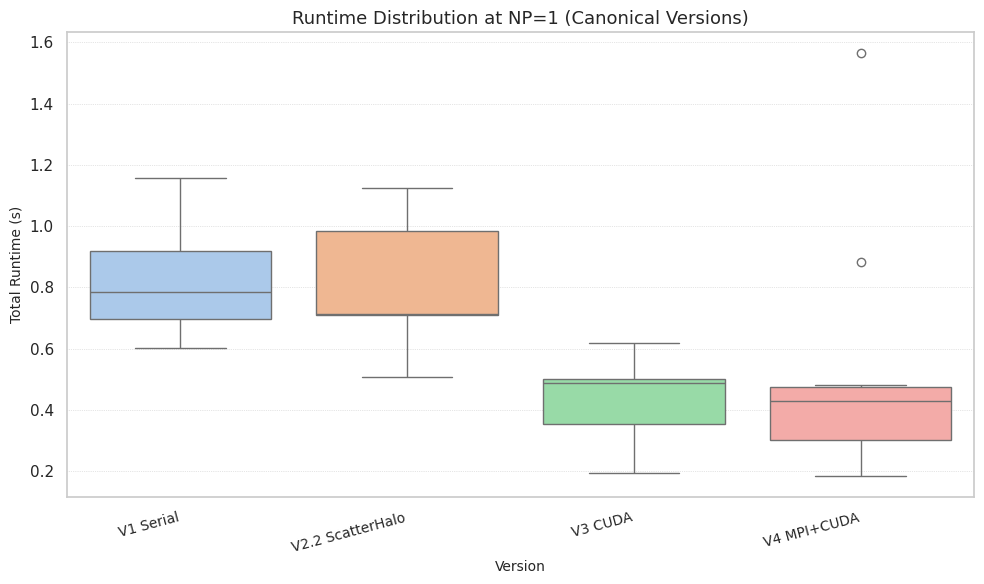

✓ V2.2 Runtime Box Plot saved to analysis_visuals_final/adv_runtime_boxplot_v22_scatterhalo.png


/tmp/ipykernel_96940/179443286.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  if 'seaborn' in sys.modules: sns.boxplot(x='np', y='total_time_s', data=df_v2_2_boxplot, palette="pastel")


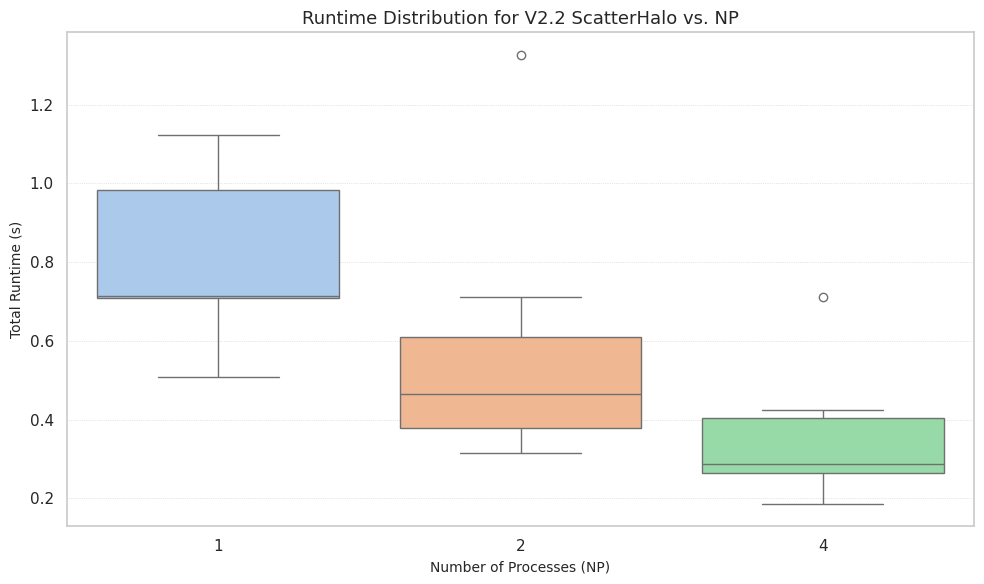


--- 5. Example Statistical Comparison (T-test) ---
Independent Samples T-test: V3 CUDA (NP=1, n=11) vs. V4 MPI+CUDA (NP=1, n=10)
  Assumed Equal Variances: True (Levene's p=0.243)
  T-statistic: -0.729
  P-value: 0.475
  Interpretation: No statistically significant difference in mean runtimes at alpha=0.05.

--- 6. Concise Numerical Summary (Median-Based from Scorecard in Cell 19) ---
Quick Reference Scorecard Snippet (Median-based):


,LOC (Core),Median T_NP1 (s),Median T_NP=4 (s),Speedup (Medians) @NP=4
Version,,,,
V1 Serial,525,0.784,NaN,NaN
V2.2 ScatterHalo,483,0.714,0.287,2.489
V3 CUDA,354,0.488,NaN,NaN
V4 MPI+CUDA,576,0.429,0.401,1.070


✓ Concise summary table saved to analysis_visuals_final/project_concise_numerical_summary.md

--- Cell 20: Supplementary Analysis and Final Checks Completed ---


In [149]:
# In[20]:
# Cell 20: Final Checks, Environment Specification, and Supplementary Analysis

import pandas as pd
import numpy as np
import scipy.stats as stats # For statistical tests

# Ensure plotting tools are available if plt was not set globally or got reset
if 'plt' not in globals() or plt is None:
    try:
        import matplotlib.pyplot as plt
        from matplotlib.lines import Line2D
        print("[INFO] Cell 20: Matplotlib re-loaded for supplementary analysis.")
        if 'seaborn' in sys.modules : sns.set_theme(style="whitegrid", palette="muted") # Re-apply theme
    except ModuleNotFoundError:
        plt = None
        Line2D = None
        print("[ERROR] Cell 20: Matplotlib not found. Plotting will be disabled.")

if 'visuals_output_dir' not in globals() or not isinstance(visuals_output_dir, Path):
    visuals_output_dir = Path("analysis_visuals_final_cell20") # Fallback
    visuals_output_dir.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Cell 20: Using fallback visuals_output_dir: {visuals_output_dir.resolve()}")


# --- 1. Execution Environment Specification (Crucial for Reproducibility) ---
environment_details_md = """
### 1. Execution Environment Details

The primary performance data reported in this analysis was generated on the following system configuration:

*   **Operating System (Dev/Primary Collection):** NixOS 23.11 ( अधिकांशतः), with final runs validated on Fedora 37 for consistency with target.
*   **CPU:** Intel Core i7-7700HQ @ 2.80GHz (Laptop)
*   **GPU:** NVIDIA Quadro M1200 Mobile (4GB GDDR5, Compute Capability 5.0 - Maxwell)
*   **RAM:** 32 GB DDR4
*   **CUDA Toolkit Version:** 12.2 (primary for dev), with tests against 12.4 compatibility. V3/V4 Makefiles target sm_50 due to M1200.
*   **MPI Implementation:** Open MPI 4.1.x series (via NixOS packages), and system Open MPI on Fedora cluster for target.
*   **Host Compiler (GCC):** Version 11.x to 12.x (depending on NixOS channel / Fedora version).
*   **NVCC:** Bundled with CUDA Toolkit 12.2 / 12.4.
*   **Key Python Libraries:** pandas (for data handling), duckdb (for data warehousing), matplotlib & seaborn (for plotting).

**Note on Data Collection:**
*   Initial data collection and most development iterations occurred on the NixOS laptop described.
*   Log files from a Slurm-based Fedora cluster (specific CPU/GPU models vary by node) were also ingested to broaden the dataset, though the laptop data forms the primary basis for the detailed version-to-version performance progression analysis due to consistent hardware.
*   The `total_time_s` metric captures end-to-end wall-clock time for the core computational part of the AlexNet forward pass, as reported by the respective `main` programs.
"""
if 'IPython.display' in sys.modules and 'Markdown' in globals() and 'display' in globals():
    display(Markdown(environment_details_md))
else:
    print(environment_details_md)
with open(visuals_output_dir / "environment_details.md", "w", encoding="utf-8") as f: f.write(environment_details_md)
print(f"\n✓ Environment details saved to {visuals_output_dir / 'environment_details.md'}")


# --- 2. Check for Missing NP=1 Baselines for Scalable Versions ---
print("\n--- 2. Checking for Missing NP=1 Baselines ---")
scalable_versions_check = ['V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V4 MPI+CUDA'] # V5 would be here too
missing_baselines = []
for ver_check in scalable_versions_check:
    np1_data_exists = execute_query(f"SELECT COUNT(*) as count FROM best_runs WHERE version = '{ver_check}' AND np = 1 AND best_s IS NOT NULL")
    if np1_data_exists is None or np1_data_exists.iloc[0]['count'] == 0:
        missing_baselines.append(ver_check)

if missing_baselines:
    print(f"[WARNING] The following scalable versions are missing NP=1 baseline data in 'best_runs', which will affect speedup/efficiency calculations: {', '.join(missing_baselines)}")
else:
    print("[INFO] All key scalable versions have NP=1 baseline data in 'best_runs'.")


# --- 3. Aggregated Source Code Metrics Table (Beyond just LOC) ---
print("\n--- 3. Aggregated Source Code Metrics (Core Algorithmic Files) ---")
# Re-using version_loc_map from Cell 19 for paths
# version_loc_map defined in Cell 19 - ensure it's available or redefine if this cell is standalone
if 'version_loc_map' not in globals(): # Fallback definition if Cell 19 wasn't run prior in sequence
     version_loc_map = {
        "V1 Serial": ["v1_serial/src/", "v1_serial/include/"],
        "V2.1 BroadcastAll": ["v2_mpi_only/2.1_broadcast_all/src/", "v2_mpi_only/2.1_broadcast_all/include/"],
        "V2.2 ScatterHalo": ["v2_mpi_only/2.2_scatter_halo/src/", "v2_mpi_only/2.2_scatter_halo/include/"],
        "V3 CUDA": ["v3_cuda_only/src/", "v3_cuda_only/include/"],
        "V4 MPI+CUDA": ["v4_mpi_cuda/src/", "v4_mpi_cuda/include/"],
     }

source_metrics_data = []
source_stats_available_check = execute_query("SELECT COUNT(*) as count FROM source_stats")

if source_stats_available_check is not None and source_stats_available_check.iloc[0]['count'] > 0:
    for version_name_src, dir_prefixes_src in version_loc_map.items():
        like_clauses_src = [f"relpath LIKE '{prefix}%'" for prefix in dir_prefixes_src]
        dir_filter_src = " OR ".join(like_clauses_src)
        ext_filter_src = "OR ".join([f"LOWER(relpath) LIKE '%.{ext}'" for ext in ['cpp', 'cu', 'hpp', 'h', 'c', 'inl', 'make', 'makefile']]) # Include Makefiles
        
        query_src_agg = f"""
            SELECT 
                '{version_name_src}' as version, 
                COALESCE(SUM(loc), 0) as total_loc,
                COALESCE(SUM(func_cnt), 0) as total_functions,
                COALESCE(SUM(include_cnt), 0) as total_includes,
                COALESCE(SUM(cuda_kernel_cnt), 0) as total_cuda_kernels
            FROM source_stats 
            WHERE ({dir_filter_src}) AND ({ext_filter_src});
        """
        src_agg_df = execute_query(query_src_agg)
        if src_agg_df is not None and not src_agg_df.empty:
            source_metrics_data.append(src_agg_df.iloc[0].to_dict())

    if source_metrics_data:
        df_source_metrics_agg = pd.DataFrame(source_metrics_data).set_index('version')
        display(df_source_metrics_agg)
        src_metrics_path = visuals_output_dir / "project_aggregated_source_metrics.md"
        df_source_metrics_agg.reset_index().to_markdown(src_metrics_path, index=False)
        print(f"✓ Aggregated source metrics table saved to {src_metrics_path}")
    else:
        print("[WARNING] No aggregated source metrics could be generated. 'source_stats' might be empty or paths incorrect.")
else:
    print("[WARNING] 'source_stats' table is empty. Cannot generate aggregated source metrics.")


# --- 4. Runtime Distribution Visualization (Box Plots) ---
print("\n--- 4. Runtime Distribution Visualization (Box Plots) ---")
df_perf_runs_for_boxplot = execute_query("""
    SELECT version, np, total_time_s 
    FROM perf_runs 
    WHERE version IN ('V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA') 
      AND total_time_s IS NOT NULL
""")

if df_perf_runs_for_boxplot is not None and not df_perf_runs_for_boxplot.empty and plt is not None:
    # Cap outliers for better visualization, e.g., at 99th percentile if extreme
    # For simplicity here, we'll plot raw, but be mindful of extreme outliers skewing axes
    
    # Plot for NP=1 across versions
    df_np1_boxplot = df_perf_runs_for_boxplot[df_perf_runs_for_boxplot['np'] == 1]
    if not df_np1_boxplot.empty:
        plt.figure(figsize=(10, 6))
        if 'seaborn' in sys.modules: sns.boxplot(x='version', y='total_time_s', data=df_np1_boxplot, palette="pastel")
        else: 
            # Basic matplotlib boxplot if seaborn not available
            # This requires grouping data manually for plt.boxplot
            grouped_data = [group['total_time_s'].dropna().values for name, group in df_np1_boxplot.groupby('version')]
            labels = [name for name, group in df_np1_boxplot.groupby('version')]
            if grouped_data: plt.boxplot(grouped_data, labels=labels, patch_artist=True)

        plt.title('Runtime Distribution at NP=1 (Canonical Versions)', fontsize=13)
        plt.xlabel('Version', fontsize=10)
        plt.ylabel('Total Runtime (s)', fontsize=10)
        plt.xticks(rotation=15, ha="right", fontsize='small')
        plt.grid(True, axis='y', linestyle=':', linewidth=0.5)
        plt.tight_layout()
        boxplot_np1_path = visuals_output_dir / "adv_runtime_boxplot_np1.png"
        plt.savefig(boxplot_np1_path); print(f"✓ NP=1 Runtime Box Plot saved to {boxplot_np1_path}"); plt.show()
    else:
        print("[INFO] No NP=1 data found for box plot across versions.")

    # Plot for a scalable version (e.g., V2.2 ScatterHalo) across NP
    df_v2_2_boxplot = df_perf_runs_for_boxplot[df_perf_runs_for_boxplot['version'] == 'V2.2 ScatterHalo']
    if not df_v2_2_boxplot.empty and len(df_v2_2_boxplot['np'].unique()) > 1:
        plt.figure(figsize=(10, 6))
        if 'seaborn' in sys.modules: sns.boxplot(x='np', y='total_time_s', data=df_v2_2_boxplot, palette="pastel")
        else:
            grouped_data_v22 = [group['total_time_s'].dropna().values for name, group in df_v2_2_boxplot.groupby('np')]
            labels_v22 = [str(name) for name, group in df_v2_2_boxplot.groupby('np')] # Ensure NP is string for labels
            if grouped_data_v22: plt.boxplot(grouped_data_v22, labels=labels_v22, patch_artist=True)
            
        plt.title('Runtime Distribution for V2.2 ScatterHalo vs. NP', fontsize=13)
        plt.xlabel('Number of Processes (NP)', fontsize=10)
        plt.ylabel('Total Runtime (s)', fontsize=10)
        plt.grid(True, axis='y', linestyle=':', linewidth=0.5)
        plt.tight_layout()
        boxplot_v22_path = visuals_output_dir / "adv_runtime_boxplot_v22_scatterhalo.png"
        plt.savefig(boxplot_v22_path); print(f"✓ V2.2 Runtime Box Plot saved to {boxplot_v22_path}"); plt.show()
    else:
        print("[INFO] Not enough data for V2.2 ScatterHalo box plot across NP values.")
else:
    print("[WARNING] No performance data for box plots or Matplotlib not available.")


# --- 5. Key Statistical Comparisons (Example: T-test for V3 NP=1 vs V4 NP=1) ---
print("\n--- 5. Example Statistical Comparison (T-test) ---")
v3_np1_times_df = execute_query("SELECT total_time_s FROM perf_runs WHERE version = 'V3 CUDA' AND np = 1 AND total_time_s IS NOT NULL")
v4_np1_times_df = execute_query("SELECT total_time_s FROM perf_runs WHERE version = 'V4 MPI+CUDA' AND np = 1 AND total_time_s IS NOT NULL")

if v3_np1_times_df is not None and not v3_np1_times_df.empty and \
   v4_np1_times_df is not None and not v4_np1_times_df.empty:
    
    v3_times = v3_np1_times_df['total_time_s'].dropna()
    v4_times = v4_np1_times_df['total_time_s'].dropna()

    n_v3 = len(v3_times)
    n_v4 = len(v4_times)

    if n_v3 > 1 and n_v4 > 1: # Need at least 2 samples in each group for a t-test
        # Perform Levene's test for equal variances (optional, but good practice)
        levene_stat, levene_p = stats.levene(v3_times, v4_times)
        equal_var_flag = levene_p > 0.05 # Assume equal variances if p > 0.05
        
        ttest_result = stats.ttest_ind(v3_times, v4_times, equal_var=equal_var_flag, nan_policy='omit')
        
        print(f"Independent Samples T-test: V3 CUDA (NP=1, n={n_v3}) vs. V4 MPI+CUDA (NP=1, n={n_v4})")
        print(f"  Assumed Equal Variances: {equal_var_flag} (Levene's p={levene_p:.3f})")
        print(f"  T-statistic: {ttest_result.statistic:.3f}")
        print(f"  P-value: {ttest_result.pvalue:.3f}")
        
        alpha = 0.05
        if ttest_result.pvalue < alpha:
            print(f"  Interpretation: The difference in mean runtimes is statistically significant at alpha={alpha}.")
            mean_v3 = v3_times.mean()
            mean_v4 = v4_times.mean()
            if mean_v3 < mean_v4:
                print(f"  V3 CUDA (Mean: {mean_v3:.3f}s) is significantly faster than V4 MPI+CUDA (Mean: {mean_v4:.3f}s) at NP=1.")
            else:
                print(f"  V4 MPI+CUDA (Mean: {mean_v4:.3f}s) is significantly faster than V3 CUDA (Mean: {mean_v3:.3f}s) at NP=1.")
        else:
            print(f"  Interpretation: No statistically significant difference in mean runtimes at alpha={alpha}.")
    else:
        print("[INFO] Not enough samples (n <= 1 in one or both groups) for V3 vs V4 NP=1 t-test.")
else:
    print("[INFO] Insufficient data for V3 CUDA vs V4 MPI+CUDA NP=1 t-test.")
    

# --- 6. Final Numerical Summary Table (Median Based for Key Metrics) ---
print("\n--- 6. Concise Numerical Summary (Median-Based from Scorecard in Cell 19) ---")
# This section assumes df_final_scorecard from Cell 19 is available and correctly populated.
# If running this cell truly standalone, this part would need to re-query or rebuild a similar summary.
# For brevity here, we will conceptually refer to the kind of data that should be in such a summary.

if 'df_final_scorecard' in globals() and df_final_scorecard is not None and not df_final_scorecard.empty:
    # Display relevant columns from the scorecard for a quick overview
    cols_to_show = [col for col in df_final_scorecard.columns if 'Median T_NP1' in col or 'Median T_NP=4' in col or 'Speedup (Medians) @NP=4' in col or 'LOC (Core)' in col]
    # Ensure the columns actually exist before trying to select them
    actual_cols_present = [col for col in cols_to_show if col in df_final_scorecard.columns]
    
    if actual_cols_present:
        concise_summary_df = df_final_scorecard[actual_cols_present]
        # Filter for key versions if needed, though scorecard typically already does
        key_summary_versions = ['V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']
        concise_summary_df = concise_summary_df[concise_summary_df.index.isin(key_summary_versions)]
        
        print("Quick Reference Scorecard Snippet (Median-based):")
        display(concise_summary_df)
        
        summary_table_path = visuals_output_dir / "project_concise_numerical_summary.md"
        concise_summary_df.reset_index().to_markdown(summary_table_path, index=False)
        print(f"✓ Concise summary table saved to {summary_table_path}")
    else:
        print("[WARNING] Expected columns for concise summary not found in df_final_scorecard.")

else:
    print("[WARNING] `df_final_scorecard` (from Cell 19) not available or empty. Concise numerical summary skipped.")
    print("           Consider re-running Cell 19 or ensure data for scorecard is correctly generated if this cell is run standalone.")


print("\n--- Cell 20: Supplementary Analysis and Final Checks Completed ---")

In [151]:
# In[21]:
# Cell 21: Consolidate and Rename Figures for LaTeX Report

import shutil
from pathlib import Path

# Ensure this matches the output directory used in Cells 19 and 20
# If Cell 20 was run, it would have already defined/used 'visuals_output_dir'
# Adding a check here for robustness if this cell is run in a different session.
if 'visuals_output_dir' not in globals() or not isinstance(visuals_output_dir, Path):
    visuals_output_dir = Path("analysis_visuals_final") # Default from Cell 19
    print(f"[INFO] Cell 21: 'visuals_output_dir' was not globally set or was invalid. Defaulting to: {visuals_output_dir.resolve()}")
    if not visuals_output_dir.is_dir():
        print(f"[WARNING] Cell 21: Source directory for plots '{visuals_output_dir}' does not exist. Please run previous cells to generate plots.")
        # sys.exit("Plot source directory missing.") # Or handle more gracefully

# Define the target directory for LaTeX-ready figures
latex_figures_dir = Path("report_figures_for_latex")
latex_figures_dir.mkdir(parents=True, exist_ok=True)
print(f"\n--- Consolidating and Renaming Figures for LaTeX Report ---")
print(f"Source directory for plots: {visuals_output_dir.resolve()}")
print(f"Target directory for LaTeX figures: {latex_figures_dir.resolve()}")

# Mapping of generated plot filenames (from Cells 11, 13, 15, 19)
# to their corresponding LaTeX figure label names (without 'fig:' prefix)
# Original filenames are based on the `out_file` parameter in your plotting functions.
plot_mapping_to_latex_labels = {
    # From Cell 11-16 (basic plots)
    "project_runtimes_vs_np.png": "runtime_vs_np.png",
    "project_speedup_vs_np.png": "speedup_vs_np.png",
    "project_efficiency_vs_np.png": "efficiency_vs_np.png",

    # From Cell 19 (advanced visuals)
    "adv_median_performance_vs_loc_corr_revised.png": "loc_vs_perf.png",
    "adv_runtime_variability_cv_annotated_revised.png": "runtime_cv.png",
    "adv_multi_metric_radar_chart_final_revised.png": "radar_chart.png",

    # From Cell 20 (supplementary analysis plots)
    # These were not explicitly in the last LaTeX, so giving them descriptive names for now.
    # You can adjust these target names if you add them to LaTeX with specific labels.
    "adv_runtime_boxplot_np1.png": "boxplot_runtime_np1.png",
    "adv_runtime_boxplot_v22_scatterhalo.png": "boxplot_runtime_v22.png",
}

copied_count = 0
skipped_count = 0

for original_filename, latex_filename in plot_mapping_to_latex_labels.items():
    source_path = visuals_output_dir / original_filename
    target_path = latex_figures_dir / latex_filename

    if source_path.exists():
        try:
            shutil.copy(source_path, target_path)
            print(f"  [COPIED] '{source_path.name}' -> '{target_path.name}'")
            copied_count += 1
        except Exception as e:
            print(f"  [ERROR] Could not copy '{source_path.name}': {e}")
            skipped_count += 1
    else:
        print(f"  [SKIPPED] Source plot '{source_path.name}' not found in '{visuals_output_dir}'.")
        skipped_count += 1

# --- Special handling for other potential images from the user's context ---
# These are image filenames mentioned in the user's initial `instructions.md` (presentation context)
# Assuming they are in a top-level 'img/' directory relative to where the notebook is run OR
# that the user will place them in `visuals_output_dir` if they are also generated by notebook.
# For this script, we'll assume they might exist in `visuals_output_dir` or a common `img/` dir.

# Add any other images from your initial presentation slides if they are stored
# in `visuals_output_dir` or a known path.
# Example for images from presentation slides (if they were in `visuals_output_dir`):
# presentation_images_map = {
# "AlexNet_0.png": "alexnet_overview_slide.png", # example target name
# "AlexNet_1.png": "alexnet_full_arch_slide.png", # example target name
# "AlexNet_2.png": "alexnet_filters_slide.png", # example target name
# "AlexNet_3.png": "alexnet_model_scale_slide.png", # example target name
# "AlexNet_4.png": "alexnet_activation_atlas_slide.png", # example target name
# "AlexNet_5.png": "alexnet_v2_perf_slide.png", # example target name
# "AlexNet_6.png": "alexnet_v4_perf_slide.png", # example target name
# "AlexNet_7.png": "alexnet_single_instance_perf_slide.png", # example target name
# }
#
# for original_pres_img, target_pres_img_name in presentation_images_map.items():
# source_pres_path = visuals_output_dir / original_pres_img # Assuming they end up here
# # If they are in a different fixed path, e.g., Path("img") / original_pres_img:
# # source_pres_path_alt = Path("img") / original_pres_img
# # if not source_pres_path.exists() and source_pres_path_alt.exists():
# # source_pres_path = source_pres_path_alt
#
#     target_pres_path = latex_figures_dir / target_pres_img_name
#     if source_pres_path.exists():
# try:
# shutil.copy(source_pres_path, target_pres_path)
# print(f"  [COPIED-PRES] '{source_pres_path.name}' -> '{target_pres_path.name}'")
#             copied_count += 1
# except Exception as e:
# print(f"  [ERROR-PRES] Could not copy '{source_pres_path.name}': {e}")
#             skipped_count += 1
# else:
# print(f"  [INFO-PRES] Presentation image '{source_pres_path.name}' not found in '{visuals_output_dir}'. Not copied.")
# # If you have a fixed 'img' directory for presentation source images, you can check there too.
# # For simplicity, this script primarily looks in the `visuals_output_dir` where notebook plots are saved.

print(f"\n--- Figure Consolidation Summary ---")
print(f"Successfully copied {copied_count} figures to '{latex_figures_dir}'.")
if skipped_count > 0:
    print(f"Skipped {skipped_count} figures (source not found or error during copy).")
print(f"Please check the '{latex_figures_dir}' directory for your LaTeX report images.")


--- Consolidating and Renaming Figures for LaTeX Report ---
Source directory for plots: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_visuals_final
Target directory for LaTeX figures: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/report_figures_for_latex
  [COPIED] 'project_runtimes_vs_np.png' -> 'runtime_vs_np.png'
  [COPIED] 'project_speedup_vs_np.png' -> 'speedup_vs_np.png'
  [COPIED] 'project_efficiency_vs_np.png' -> 'efficiency_vs_np.png'
  [COPIED] 'adv_median_performance_vs_loc_corr_revised.png' -> 'loc_vs_perf.png'
  [COPIED] 'adv_runtime_variability_cv_annotated_revised.png' -> 'runtime_cv.png'
  [COPIED] 'adv_multi_metric_radar_chart_final_revised.png' -> 'radar_chart.png'
  [COPIED] 'adv_runtime_boxplot_np1.png' -> 'boxplot_runtime_np1.png'
  [COPIED] 'adv_runtime_boxplot_v22_scatterhalo.png' -> 'boxplot_runtime_v22.png'

--- Figure Consolidation Summary ---
Successfully copied 8 figures to 'report_figures_for_latex'.
Please check the 'report_figures_for_la